**Data Collection and Loading**

In [ ]:
!pip3 install pyspark
from pyspark.sql import SparkSession, types

spark = SparkSession.builder.appName("UKClimateAnomalies ")\
.config("spark.executor.memory","8g")\
.config("spark.driver.memory","5g")\
.config("sspark.memory.offHeap.enabled","true")\
.config("spark.memory.offHeap.size","512m")\
.getOrCreate()

from google.colab import drive
drive.mount('/content/drive')


uk_climate_df = spark.read.csv("/content/drive/MyDrive/Dissertation/nasa_climate_uk_2020-2024.csv",header=True,inferSchema=True)
uk_climate_df.show(truncate=False)
uk_climate_df.describe().show()
uk_climate_df.printSchema()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
+---------+-----+-------+-------+-----+-----------+----+-----------------+-----------------+------+-----+---------+----------+------+
|Date     |T2M  |T2M_MAX|T2M_MIN|RH2M |PRECTOTCORR|WS2M|ALLSKY_SFC_SW_DWN|CLRSKY_SFC_SW_DWN|PS    |TQV  |CLOUD_AMT|TOA_SW_DWN|City  |
+---------+-----+-------+-------+-----+-----------+----+-----------------+-----------------+------+-----+---------+----------+------+
|1/1/2020 |3.38 |5.49   |1.28   |97.91|0.19       |1.21|0.499            |1.0853           |101.97|9.69 |78.33    |1.8941    |London|
|1/2/2020 |7.04 |8.95   |3.99   |96.15|0.3        |4.15|0.3574           |0.9118           |101.08|11.86|90.33    |1.909     |London|
|1/3/2020 |6.24 |9.78   |1.74   |93.01|2.97       |4.16|0.9017           |1.1815           |101.2 |13.85|73.49    |1.9253    |London|
|1/4/2020 |3.96 |7.74   |1.97   |96.34|0.04       |3.09|0.737      

**Pre-Processing and Feature Engineering**

In [ ]:
from pyspark.sql import functions as F

ukClimateBaseDF = (
    uk_climate_df
    .withColumnRenamed("Date","DATE_RAW")
    .withColumnRenamed("City","CITY")
    .withColumn("CITY", F.trim(F.col("CITY").cast("string")))
    .filter(F.col("CITY").isNotNull() & (F.col("CITY")!=""))
)

ukClimateBaseDF.select("CITY").distinct().orderBy("CITY").show(50, False)



+----------+
|CITY      |
+----------+
|Belfast   |
|Birmingham|
|Cardiff   |
|Edinburgh |
|Glasgow   |
|London    |
|Manchester|
+----------+



In [ ]:
import numpy as np
from pyspark.sql import functions as F
from pyspark.sql.window import Window

#Parse DATE_RAW → DATE_DAY
isNumericDate = ukClimateBaseDF.select(
    F.sum(F.when(F.col("DATE_RAW").cast("double").isNotNull(), 1).otherwise(0)).alias("n")
).collect()[0]["n"]

if isNumericDate and isNumericDate > 0:
    workDF = ukClimateBaseDF.withColumn("DATE_NUM", F.col("DATE_RAW").cast("double"))
    workDF = workDF.withColumn(
        "DATE_DAY",
        F.expr("date_add(to_date('1899-12-30'), CAST(DATE_NUM AS INT))").cast("date")
    ).drop("DATE_NUM")
else:
    fmts = ["M/d/yyyy","d/M/yyyy","MM/dd/yyyy","dd/MM/yyyy","yyyy-MM-dd"]
    expr = F.to_date("DATE_RAW", fmts[0])
    for f in fmts[1:]:
        expr = F.coalesce(expr, F.to_date("DATE_RAW", f))
    expr = F.coalesce(expr, F.to_date("DATE_RAW"))
    workDF = ukClimateBaseDF.withColumn("DATE_DAY", expr.cast("date"))

#Cast numerics
numericAll = ["T2M","T2M_MAX","T2M_MIN","RH2M","PRECTOTCORR","WS2M",
              "ALLSKY_SFC_SW_DWN","CLRSKY_SFC_SW_DWN","PS","TQV","CLOUD_AMT","TOA_SW_DWN"]
for c in numericAll:
    if c in workDF.columns:
        workDF = workDF.withColumn(c, F.col(c).cast("double"))

#Unit normalisation
cloudMax = workDF.agg(F.max("CLOUD_AMT").alias("mx")).collect()[0]["mx"]
if cloudMax is not None and cloudMax <= 1.2:
    workDF = workDF.withColumn("CLOUD_AMT", F.col("CLOUD_AMT")*100.0)

pressureMedian = workDF.where(F.col("PS").isNotNull()).approxQuantile("PS",[0.5],0.01)
pressureMedian = pressureMedian[0] if pressureMedian else None
workDF = workDF.withColumn(
    "PS_HPA",
    F.when(F.lit(pressureMedian).isNotNull() & (F.lit(pressureMedian)<=200), F.col("PS")*10.0).otherwise(F.col("PS"))
)

#Complete daily calendar per city
boundsDF = (workDF.groupBy("CITY")
            .agg(F.min("DATE_DAY").alias("MIN_DAY"), F.max("DATE_DAY").alias("MAX_DAY"))
            .filter(F.col("MIN_DAY").isNotNull() & F.col("MAX_DAY").isNotNull()))
calendarDF = (boundsDF.withColumn("DATE_DAY", F.explode(F.expr("sequence(MIN_DAY, MAX_DAY, interval 1 day)")))
                        .select("CITY","DATE_DAY"))
completeDF = calendarDF.join(workDF, on=["CITY","DATE_DAY"], how="left")

#Physical range QC
def inRange(colName, lo, hi):
    return F.when((F.col(colName)<lo)|(F.col(colName)>hi), None).otherwise(F.col(colName))

qcDF = (completeDF
        .withColumn("T2M", inRange("T2M",-25,45))
        .withColumn("T2M_MAX", inRange("T2M_MAX",-25,55))
        .withColumn("T2M_MIN", inRange("T2M_MIN",-40,40))
        .withColumn("RH2M", inRange("RH2M",0,100))
        .withColumn("PRECTOTCORR", F.when(F.col("PRECTOTCORR")<0,None).otherwise(F.col("PRECTOTCORR")))
        .withColumn("WS2M", F.when(F.col("WS2M")<0,None).otherwise(F.col("WS2M")))
        .withColumn("ALLSKY_SFC_SW_DWN", F.when(F.col("ALLSKY_SFC_SW_DWN")<0,None).otherwise(F.col("ALLSKY_SFC_SW_DWN")))
        .withColumn("CLRSKY_SFC_SW_DWN", F.when(F.col("CLRSKY_SFC_SW_DWN")<0,None).otherwise(F.col("CLRSKY_SFC_SW_DWN")))
        .withColumn("TOA_SW_DWN", F.when(F.col("TOA_SW_DWN")<0,None).otherwise(F.col("TOA_SW_DWN")))
        .withColumn("TQV", F.when(F.col("TQV")<0,None).otherwise(F.col("TQV")))
        .withColumn("CLOUD_AMT", inRange("CLOUD_AMT",0,100))
        .withColumn("PS_HPA", inRange("PS_HPA",950,1050))
)

#Keep pre-imputation NA flags
numericForQC = ["T2M","T2M_MAX","T2M_MIN","RH2M","PRECTOTCORR","WS2M",
                "ALLSKY_SFC_SW_DWN","CLRSKY_SFC_SW_DWN","TOA_SW_DWN","TQV","CLOUD_AMT","PS_HPA"]
for c in numericForQC:
    qcDF = qcDF.withColumn(f"{c}_WAS_NA", F.col(c).isNull().cast("int"))

#≤1-day interpolation + 1-day ffill/bfill
windowCity = Window.partitionBy("CITY").orderBy("DATE_DAY")
impDF = qcDF
for c in numericForQC:
    impDF = (impDF
        .withColumn(f"{c}_LAG", F.lag(c).over(windowCity))
        .withColumn(f"{c}_LEAD", F.lead(c).over(windowCity))
        .withColumn("DAY_LAG", F.lag("DATE_DAY").over(windowCity))
        .withColumn("DAY_LEAD", F.lead("DATE_DAY").over(windowCity))
    )

def interpOne(name):
    return F.when(
        F.col(name).isNull() &
        F.col(f"{name}_LAG").isNotNull() & F.col(f"{name}_LEAD").isNotNull() &
        (F.datediff(F.col("DATE_DAY"),F.col("DAY_LAG"))==1) &
        (F.datediff(F.col("DAY_LEAD"),F.col("DATE_DAY"))==1),
        (F.col(f"{name}_LAG")+F.col(f"{name}_LEAD"))/2.0
    ).otherwise(F.col(name))

for c in numericForQC:
    impDF = impDF.withColumn(c, interpOne(c))
    impDF = impDF.withColumn(c, F.when(
        F.col(c).isNull() & F.col(f"{c}_LAG").isNotNull() & (F.datediff(F.col("DATE_DAY"),F.col("DAY_LAG"))==1),
        F.col(f"{c}_LAG")).otherwise(F.col(c)))
    impDF = impDF.withColumn(c, F.when(
        F.col(c).isNull() & F.col(f"{c}_LEAD").isNotNull() & (F.datediff(F.col("DAY_LEAD"),F.col("DATE_DAY"))==1),
        F.col(f"{c}_LEAD")).otherwise(F.col(c)))

dropHelpers = [f"{c}_LAG" for c in numericForQC] + [f"{c}_LEAD" for c in numericForQC] + ["DAY_LAG","DAY_LEAD"]
impDF = impDF.drop(*[c for c in dropHelpers if c in impDF.columns])

#Rolling features (7/30/90) + EXTRA features
rollingWindows = [7,30,90]
orderWindow = Window.partitionBy("CITY").orderBy("DATE_DAY")
featVars = ["T2M","RH2M","PRECTOTCORR","WS2M","ALLSKY_SFC_SW_DWN","CLOUD_AMT","PS_HPA"]

featuresDF = impDF
for v in featVars:
    for w in rollingWindows:
        spec = orderWindow.rowsBetween(-w+1,0)
        featuresDF = (featuresDF
            .withColumn(f"{v}_MEAN_{w}D", F.avg(v).over(spec))
            .withColumn(f"{v}_STD_{w}D",  F.stddev_samp(v).over(spec))
            .withColumn(f"{v}_DEV_{w}D",  F.col(v)-F.col(f"{v}_MEAN_{w}D"))
            .withColumn(f"{v}_Z_{w}D",    F.col(f"{v}_DEV_{w}D")/(F.col(f"{v}_STD_{w}D")+F.lit(1e-9)))
        )

#Engineered extras (yours + new):
featuresDF = featuresDF.withColumn("TEMP_SPREAD_C", F.col("T2M_MAX")-F.col("T2M_MIN"))
featuresDF = featuresDF.withColumn(
    "RAD_RATIO",
    F.when(F.col("CLRSKY_SFC_SW_DWN").isNull() | (F.col("CLRSKY_SFC_SW_DWN")<=0), None)
     .otherwise(F.col("ALLSKY_SFC_SW_DWN")/(F.col("CLRSKY_SFC_SW_DWN")+F.lit(1e-9)))
)
featuresDF = featuresDF.withColumn("DAY_OF_YEAR", F.dayofyear("DATE_DAY"))
featuresDF = featuresDF.withColumn("DOY_SIN", F.sin(2*np.pi*F.col("DAY_OF_YEAR")/365.25))
featuresDF = featuresDF.withColumn("DOY_COS", F.cos(2*np.pi*F.col("DAY_OF_YEAR")/365.25))
featuresDF = featuresDF.withColumn("THERMO_HYGRO_STRESS_Z", (F.abs(F.col("T2M_Z_30D")) + F.abs(F.col("RH2M_Z_30D")))/2.0)
#daily temp change & 30D precip sum
featuresDF = featuresDF.withColumn("T2M_CHG_1D", F.col("T2M") - F.lag("T2M").over(orderWindow))
featuresDF = featuresDF.withColumn("PRECIP_SUM_30D", F.sum("PRECTOTCORR").over(orderWindow.rowsBetween(-29,0)))

#Missingness counters
preNaFlags = [f"{c}_WAS_NA" for c in numericForQC]
for w in [7,30]:
    rs = None
    for f in preNaFlags:
        part = F.sum(F.col(f)).over(orderWindow.rowsBetween(-w+1,0))
        rs = part if rs is None else rs + part
    featuresDF = featuresDF.withColumn(f"MISSINGNESS_SUM_{w}D", rs)

featuresDF.groupBy("CITY").agg(F.count("*").alias("rows")).orderBy("CITY").show(50, False)


+----------+----+
|CITY      |rows|
+----------+----+
|Belfast   |1827|
|Birmingham|1827|
|Cardiff   |1827|
|Edinburgh |1827|
|Glasgow   |1827|
|London    |1827|
|Manchester|1827|
+----------+----+



In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

baseVars = ["T2M","T2M_MAX","T2M_MIN","RH2M","PRECTOTCORR","WS2M","ALLSKY_SFC_SW_DWN","CLOUD_AMT","PS_HPA"]
z30Vars = [f"{c}_Z_30D" for c in ["T2M","RH2M","PRECTOTCORR","WS2M","ALLSKY_SFC_SW_DWN","CLOUD_AMT","PS_HPA"]]
dev7Vars = [f"{c}_DEV_7D" for c in ["T2M","RH2M","PRECTOTCORR","WS2M","ALLSKY_SFC_SW_DWN","CLOUD_AMT","PS_HPA"]]
extraVars = ["TEMP_SPREAD_C","RAD_RATIO","DOY_SIN","DOY_COS","MISSINGNESS_SUM_7D","MISSINGNESS_SUM_30D",
             "T2M_CHG_1D","PRECIP_SUM_30D"]  # added
featureList = baseVars + z30Vars + dev7Vars + extraVars

cities = [r.asDict()["CITY"] for r in featuresDF.select("CITY").distinct().collect()]
print("Discovered cities:", cities)

cityData = {}
for city in cities:
    cityDF = featuresDF.filter(F.col("CITY")==city).orderBy("DATE_DAY")
    pdf = cityDF.toPandas()
    pdf["DATE_DAY"] = pd.to_datetime(pdf["DATE_DAY"])
    pdf = pdf.dropna(subset=featureList)
    pdf["YEAR"] = pdf["DATE_DAY"].dt.year

    trainPDF = pdf[(pdf["YEAR"]>=2020)&(pdf["YEAR"]<=2022)].copy()
    valPDF   = pdf[pdf["YEAR"]==2023].copy()
    testPDF  = pdf[pdf["YEAR"]==2024].copy()

    for frame in (trainPDF, valPDF, testPDF):
        if len(frame)>0:
            frame[featureList] = frame[featureList].apply(pd.to_numeric, errors="coerce").astype("float64")

    scaler = MinMaxScaler()
    if len(trainPDF)>0: trainPDF.loc[:, featureList] = scaler.fit_transform(trainPDF[featureList])
    if len(valPDF)>0:   valPDF.loc[:, featureList]   = scaler.transform(valPDF[featureList])
    if len(testPDF)>0:  testPDF.loc[:, featureList]  = scaler.transform(testPDF[featureList])

    cityData[city] = {"features": featureList, "scaler": scaler, "train": trainPDF, "val": valPDF, "test": testPDF}

pd.DataFrame([
    {"City":c, "Train":len(cityData[c]["train"]), "Val":len(cityData[c]["val"]), "Test":len(cityData[c]["test"])}
    for c in cities
]).sort_values("City")


Discovered cities: ['Edinburgh', 'Manchester', 'Glasgow', 'Belfast', 'Cardiff', 'London', 'Birmingham']


City  Train  Val  Test
3     Belfast   1095  365   366
6  Birmingham   1095  365   366
4     Cardiff   1095  365   366
0   Edinburgh   1095  365   366
2     Glasgow   1095  365   366
5      London   1095  365   366
1  Manchester   1095  365   366

In [ ]:
import numpy as np
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             precision_recall_curve, roc_auc_score, auc)

def makeWeakLabels(frame, rate=0.02):
    zcols = [c for c in frame.columns if c.endswith("_Z_30D")]
    comp = frame[zcols].abs().max(axis=1)
    thr = comp.quantile(1-rate) if comp.notna().any() else comp.max()
    y = (comp >= thr).astype(int)
    if y.sum()==0 and len(y)>0: y.iloc[-1]=1
    return y.values

def scale01(arr):
    arr = np.asarray(arr, dtype=float)
    return (arr - np.nanmin(arr)) / (np.nanmax(arr) - np.nanmin(arr) + 1e-9)

def compute_metrics(y_true, y_pred, scores):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    #PR-AUC
    pr_prec, pr_rec, _ = precision_recall_curve(y_true, scores)
    pr_auc = float(auc(pr_rec, pr_prec)) if y_true.sum()>0 else 0.0
    #ROC-AUC
    try:
        roc = roc_auc_score(y_true, scores) if 0 < y_true.sum() < len(y_true) else np.nan
    except Exception:
        roc = np.nan
    return {"accuracy":acc, "precision":prec, "recall":rec, "f1":f1, "pr_auc":pr_auc, "roc_auc":roc}


**Model Implementation**

In [ ]:
#IsolationForest
import time
from sklearn.ensemble import IsolationForest

paramGridIF = {
    "n_estimators":[100,200,400],
    "max_samples":[256,512,"auto"],
    "max_features":[0.8,1.0],
    "contamination":[0.01,0.02,0.03]
}
quantiles = np.linspace(0.90,0.99,30)
resultsIF = {}

for city in cities:
    t0 = time.time()
    feats = cityData[city]["features"]
    tr = cityData[city]["train"]; va = cityData[city]["val"]; te = cityData[city]["test"]
    if len(tr)==0 or len(va)==0 or len(te)==0:
        print(f"[IF] {city}: skipped (empty split)")
        continue

    Xtr, Xva, Xte = tr[feats].values, va[feats].values, te[feats].values
    yVal = makeWeakLabels(va, rate=0.02)
    yTest= makeWeakLabels(te, rate=0.02)

    best = {"f1":-1}
    for ne in paramGridIF["n_estimators"]:
        for ms in paramGridIF["max_samples"]:
            for mf in paramGridIF["max_features"]:
                for cont in paramGridIF["contamination"]:
                    model = IsolationForest(n_estimators=ne, max_samples=ms, max_features=mf,
                                            contamination=cont, bootstrap=False, random_state=42).fit(Xtr)
                    sVal = scale01(-model.score_samples(Xva))
                    for q in quantiles:
                        thr = np.quantile(sVal, q)
                        f1 = f1_score(yVal, (sVal>=thr).astype(int), zero_division=0)
                        if f1 > best["f1"]:
                            best = {"f1":float(f1), "thr":float(thr),
                                    "params":{"n_estimators":ne,"max_samples":ms,"max_features":mf,"contamination":cont},
                                    "model":model}

    sTest = scale01(-best["model"].score_samples(Xte))
    yHat  = (sTest >= best["thr"]).astype(int)
    mets  = compute_metrics(yTest, yHat, sTest)
    execSecs = time.time()-t0
    resultsIF[city] = {
        "params": best["params"], "threshold": best["thr"], "metrics": mets,
        "anomalies_test": int(yHat.sum()), "test_len": int(len(yHat)), "exec_secs": round(execSecs,2)
    }
    print(f"[IF] {city} | PR-AUC={mets['pr_auc']:.2f} | F1={mets['f1']:.2f} | Anoms={yHat.sum()}/{len(yHat)} | {execSecs:.2f}s")


[IF] Edinburgh | PR-AUC=0.17 | F1=0.20 | Anoms=2/366 | 35.50s
[IF] Manchester | PR-AUC=0.31 | F1=0.27 | Anoms=7/366 | 32.94s
[IF] Glasgow | PR-AUC=0.11 | F1=0.00 | Anoms=1/366 | 33.75s
[IF] Belfast | PR-AUC=0.30 | F1=0.40 | Anoms=2/366 | 39.63s
[IF] Cardiff | PR-AUC=0.22 | F1=0.15 | Anoms=5/366 | 36.85s
[IF] London | PR-AUC=0.61 | F1=0.50 | Anoms=4/366 | 32.70s
[IF] Birmingham | PR-AUC=0.42 | F1=0.33 | Anoms=10/366 | 35.12s


In [ ]:
#Extended IsolationForest
!pip install h2o
import h2o, time
from h2o.estimators.extended_isolation_forest import H2OExtendedIsolationForestEstimator

try:
    h2o.init(max_mem_size="4G", nthreads=-1)
except:
    h2o.connect()

grid_ntrees = [100, 200]
grid_sample_size = [256, 512]
grid_extension_level = [1, 2]
quantiles = np.linspace(0.90, 0.99, 30)

resultsEIF = {}

for city in cities:
    t0 = time.time()
    feats = cityData[city]["features"]
    tr = cityData[city]["train"]; va = cityData[city]["val"]; te = cityData[city]["test"]
    if len(tr)==0 or len(va)==0 or len(te)==0:
        print(f"[EIF] {city}: skipped (empty split)")
        continue

    tr_h2o = h2o.H2OFrame(tr[feats])
    va_h2o = h2o.H2OFrame(va[feats])
    te_h2o = h2o.H2OFrame(te[feats])

    yVal = makeWeakLabels(va, rate=0.02)
    yTest= makeWeakLabels(te, rate=0.02)

    best = {"f1":-1}
    for nt in grid_ntrees:
        for ss in grid_sample_size:
            for ext in grid_extension_level:
                eif = H2OExtendedIsolationForestEstimator(ntrees=nt, sample_size=ss, extension_level=ext, seed=42)
                eif.train(x=feats, training_frame=tr_h2o)

                pred_val = eif.predict(va_h2o)
                score_col = "anomaly_score" if "anomaly_score" in pred_val.columns else pred_val.columns[0]
                sVal = scale01(pred_val[score_col].as_data_frame(use_multi_thread=True)[score_col].to_numpy())

                for q in quantiles:
                    thr = np.nanquantile(sVal, q)
                    f1 = f1_score(yVal, (sVal>=thr).astype(int), zero_division=0)
                    if f1 > best["f1"]:
                        best = {"f1":float(f1), "thr":float(thr),
                                "params":{"ntrees":nt,"sample_size":ss,"extension_level":ext},
                                "model":eif}

    pred_test = best["model"].predict(te_h2o)
    score_col = "anomaly_score" if "anomaly_score" in pred_test.columns else pred_test.columns[0]
    sTest = scale01(pred_test[score_col].as_data_frame(use_multi_thread=True)[score_col].to_numpy())
    yHat  = (sTest >= best["thr"]).astype(int)
    mets  = compute_metrics(yTest, yHat, sTest)
    execSecs = time.time()-t0
    resultsEIF[city] = {
        "params": best["params"], "threshold": best["thr"], "metrics": mets,
        "anomalies_test": int(yHat.sum()), "test_len": int(len(yHat)), "exec_secs": round(execSecs,2)
    }
    print(f"[EIF] {city} | PR-AUC={mets['pr_auc']:.2f} | F1={mets['f1']:.2f} | Anoms={yHat.sum()}/{len(yHat)} | {execSecs:.2f}s")


Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         3 hours 5 mins
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.7
H2O_cluster_version_age:    5 months and 2 days
H2O_cluster_name:           H2O_from_python_unknownUser_eqs89w
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    2.092 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.12.11 final
--------------------------  -----------------------------------------------------------------------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |████

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
[EIF] Manchester | PR-AUC=0.19 | F1=0.33 | Anoms=4/366 | 21.91s
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
[EIF] Belfast | PR-AUC=0.30 | F1=0.15 | Anoms=18/366 | 20.37s
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
[EIF] Cardiff | PR-AUC=0.24 | F1=0.20 | Anoms=2/366 | 21.60s
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
[EIF] London | PR-AUC=0.62 | F1=0.48 | Anoms=13/366 | 22.72s
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
[EIF] Birmingham | PR-AUC=0.35 | F1=0.33 | Anoms=10/366 | 21.93s


In [ ]:
#LocalOutlierFactor
import time
from sklearn.neighbors import LocalOutlierFactor

def lofWindowScores(X, k=200):
    scores = np.full(X.shape[0], np.nan)
    for i in range(k, X.shape[0]):
        window = X[i-k:i+1]
        nNeigh = max(5, min(k, len(window)-1))
        lof = LocalOutlierFactor(n_neighbors=nNeigh, novelty=False, contamination="auto", n_jobs=-1)
        lof.fit(window)
        winScores = -lof.negative_outlier_factor_
        s01 = (winScores - winScores.min())/(winScores.max()-winScores.min()+1e-9)
        scores[i] = s01[-1]
    if np.isnan(scores[:k]).all():  # cold start guard
        fill = np.nanmin(scores[k:]) if np.any(~np.isnan(scores[k:])) else 0.0
        scores[:k] = fill
    return scores

resultsLOF = {}
quantiles_lof = np.linspace(0.90,0.99,30)

for city in cities:
    t0 = time.time()
    feats = cityData[city]["features"]
    va = cityData[city]["val"]; te = cityData[city]["test"]
    if len(va)==0 or len(te)==0:
        print(f"[LOF-200] {city}: skipped (empty split)")
        continue

    Xva, Xte = va[feats].values, te[feats].values
    yVal = makeWeakLabels(va, rate=0.02)
    yTest= makeWeakLabels(te, rate=0.02)

    sVal = lofWindowScores(Xva, k=200)
    best = {"f1":-1}
    for q in quantiles_lof:
        thr = np.quantile(sVal[np.isfinite(sVal)], q)
        f1  = f1_score(yVal, (sVal>=thr).astype(int), zero_division=0)
        if f1>best["f1"]:
            best = {"f1":float(f1), "thr":float(thr)}

    sTest = lofWindowScores(Xte, k=200)
    yHat  = (sTest>=best["thr"]).astype(int)
    mets  = compute_metrics(yTest, yHat, sTest)
    execSecs = time.time()-t0
    resultsLOF[city] = {
        "params": {"k":200}, "threshold": best["thr"], "metrics": mets,
        "anomalies_test": int(yHat.sum()), "test_len": int(len(yHat)), "exec_secs": round(execSecs,2)
    }
    print(f"[LOF-200] {city} | PR-AUC={mets['pr_auc']:.2f} | F1={mets['f1']:.2f} | Anoms={yHat.sum()}/{len(yHat)} | {execSecs:.2f}s")


[LOF-200] Edinburgh | PR-AUC=0.02 | F1=0.03 | Anoms=58/366 | 2.55s
[LOF-200] Manchester | PR-AUC=0.02 | F1=0.00 | Anoms=75/366 | 7.19s
[LOF-200] Glasgow | PR-AUC=0.02 | F1=0.00 | Anoms=50/366 | 4.70s
[LOF-200] Belfast | PR-AUC=0.01 | F1=0.00 | Anoms=92/366 | 5.13s
[LOF-200] Cardiff | PR-AUC=0.02 | F1=0.00 | Anoms=64/366 | 3.95s
[LOF-200] London | PR-AUC=0.02 | F1=0.00 | Anoms=32/366 | 2.54s
[LOF-200] Birmingham | PR-AUC=0.02 | F1=0.00 | Anoms=38/366 | 2.55s


**Evaluation and Metrics**

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix

def flatten(city, modelName, res):
    m = res["metrics"]
    return {
        "City": city, "Model": modelName,
        "Accuracy": m["accuracy"], "Precision": m["precision"], "Recall": m["recall"], "F1": m["f1"],
        "PR_AUC": m["pr_auc"], "ROC_AUC": m["roc_auc"],
        "Exec_Secs": res["exec_secs"],
        "Threshold": res["threshold"],
        "Params": res["params"],
        "Pred_Anomalies": res["anomalies_test"], "Test_Rows": res["test_len"]
    }

rows = []
for city in cities:
    if city in resultsIF:  rows.append(flatten(city, "IsolationForest", resultsIF[city]))
    if city in resultsEIF: rows.append(flatten(city, "H2O-EIF",        resultsEIF[city]))
    if city in resultsLOF: rows.append(flatten(city, "LOF-200",        resultsLOF[city]))

metricsPerCityModel = pd.DataFrame(rows).sort_values(["City","Model"]).reset_index(drop=True)
display(metricsPerCityModel)

# Macro averages per model (mean across cities)
macro = (metricsPerCityModel
         .groupby("Model")[["Accuracy","Precision","Recall","F1","PR_AUC","ROC_AUC","Exec_Secs"]]
         .mean(numeric_only=True).reset_index())
print("\nMacro averages (mean across cities):")
display(macro)

# Micro (pooled) precision/recall/F1 require pooled TP/FP/FN;
# approximate micro F1 via weighted averages by Test_Rows (proxy).
micro = (metricsPerCityModel
         .groupby("Model")
         .apply(lambda g: pd.Series({
             "Cities": len(g),
             "Weighted_F1": (g["F1"]*g["Test_Rows"]).sum()/g["Test_Rows"].sum(),
             "Weighted_PR_AUC": (g["PR_AUC"]*g["Test_Rows"]).sum()/g["Test_Rows"].sum(),
             "Total_Exec_Secs": g["Exec_Secs"].sum()
         }))
         .reset_index())
print("\nMicro-style weighted summary:")
display(micro)


City            Model  Accuracy  Precision  Recall        F1  \
0      Belfast          H2O-EIF  0.939891   0.111111   0.250  0.153846   
1      Belfast  IsolationForest  0.983607   1.000000   0.250  0.400000   
2      Belfast          LOF-200  0.726776   0.000000   0.000  0.000000   
3   Birmingham          H2O-EIF  0.967213   0.300000   0.375  0.333333   
4   Birmingham  IsolationForest  0.967213   0.300000   0.375  0.333333   
5   Birmingham          LOF-200  0.874317   0.000000   0.000  0.000000   
6      Cardiff          H2O-EIF  0.978142   0.500000   0.125  0.200000   
7      Cardiff  IsolationForest  0.969945   0.200000   0.125  0.153846   
8      Cardiff          LOF-200  0.803279   0.000000   0.000  0.000000   
9    Edinburgh          H2O-EIF  0.980874   1.000000   0.125  0.222222   
10   Edinburgh  IsolationForest  0.978142   0.500000   0.125  0.200000   
11   Edinburgh          LOF-200  0.825137   0.017241   0.125  0.030303   
12     Glasgow          H2O-EIF  0.959016   0.181818   0.250  0.210526   
13     Glasgow  IsolationForest  0.975410   0.000000   0.000  0.000000   
14     Glasgow          LOF-200  0.841530   0.000000   0.000  0.000000   
15      London          H2O-EIF  0.969945   0.384615   0.625  0.476190   
16      London  IsolationForest  0.983607   0.750000   0.375  0.500000   
17      London          LOF-200  0.890710   0.000000   0.000  0.000000   
18  Manchester          H2O-EIF  0.978142   0.500000   0.250  0.333333   
19  Manchester  IsolationForest  0.969945   0.285714   0.250  0.266667   
20  Manchester          LOF-200  0.773224   0.000000   0.000  0.000000   

      PR_AUC   ROC_AUC  Exec_Secs  Threshold  \
0   0.295891  0.780028      20.37   0.533705   
1   0.300780  0.814944      39.63   0.728735   
2   0.014313  0.343575       5.13   0.549079   
3   0.354973  0.828561      21.93   0.675700   
4   0.415156  0.837291      35.12   0.717049   
5   0.021759  0.511173       2.55   0.667405   
6   0.237423  0.747905      21.60   0.774225   
7   0.215914  0.748953      36.85   0.796900   
8   0.019738  0.464036       3.95   0.600709   
9   0.184978  0.787360      20.01   0.877873   
10  0.169443  0.770251      35.50   0.883804   
11  0.024762  0.580307       2.55   0.620115   
12  0.228477  0.822975      20.22   0.735649   
13  0.114580  0.790503      33.75   0.953012   
14  0.024376  0.567039       4.70   0.604450   
15  0.620926  0.961243      22.72   0.522501   
16  0.610501  0.949372      32.70   0.672087   
17  0.019632  0.463163       2.54   0.645409   
18  0.192506  0.912709      21.91   0.739134   
19  0.312090  0.861732      32.94   0.709407   
20  0.018194  0.446229       7.19   0.624105   

                                               Params  Pred_Anomalies  \
0   {'ntrees': 100, 'sample_size': 256, 'extension...              18   
1   {'n_estimators': 100, 'max_samples': 512, 'max...               2   
2                                          {'k': 200}              92   
3   {'ntrees': 100, 'sample_size': 256, 'extension...              10   
4   {'n_estimators': 100, 'max_samples': 512, 'max...              10   
5                                          {'k': 200}              38   
6   {'ntrees': 100, 'sample_size': 512, 'extension...               2   
7   {'n_estimators': 100, 'max_samples': 256, 'max...               5   
8                                          {'k': 200}              64   
9   {'ntrees': 200, 'sample_size': 256, 'extension...               1   
10  {'n_estimators': 100, 'max_samples': 256, 'max...               2   
11                                         {'k': 200}              58   
12  {'ntrees': 100, 'sample_size': 256, 'extension...              11   
13  {'n_estimators': 100, 'max_samples': 512, 'max...               1   
14                                         {'k': 200}              50   
15  {'ntrees': 200, 'sample_size': 512, 'extension...              13   
16  {'n_estimators': 100, 'max_samples': 256, 'max...               4   
17        


Macro averages (mean across cities):


Model  Accuracy  Precision    Recall        F1    PR_AUC  \
0          H2O-EIF  0.967603   0.425364  0.285714  0.275636  0.302168   
1  IsolationForest  0.975410   0.433673  0.214286  0.264835  0.305495   
2          LOF-200  0.819282   0.002463  0.017857  0.004329  0.020396   

    ROC_AUC  Exec_Secs  
0  0.834397  21.251429  
1  0.824721  35.212857  
2  0.482218   4.087143


Micro-style weighted summary:


/tmp/ipython-input-1030703222.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


Model  Cities  Weighted_F1  Weighted_PR_AUC  Total_Exec_Secs
0          H2O-EIF     7.0     0.275636         0.302168           148.76
1  IsolationForest     7.0     0.264835         0.305495           246.49
2          LOF-200     7.0     0.004329         0.020396            28.61

In [ ]:

# Novelty-LOF (stable unsupervised scoring)
# - Fit once per city on Train(2020–22)
# - Tune a global score quantile on Val(2023) vs weak labels
# - Apply to Test(2024)

import time, numpy as np, pandas as pd
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import f1_score

quantiles_nlof = np.linspace(0.85, 0.99, 30)
resultsLOF_novelty = {}

for city in cities:
    t0 = time.time()
    feats = cityData[city]["features"]
    tr = cityData[city]["train"]; va = cityData[city]["val"]; te = cityData[city]["test"]
    if len(tr)==0 or len(va)==0 or len(te)==0:
        print(f"[Novelty-LOF] {city}: skipped (empty split)")
        continue

    Xtr, Xva, Xte = tr[feats].values, va[feats].values, te[feats].values
    yVal = makeWeakLabels(va, rate=0.02)
    yTest= makeWeakLabels(te, rate=0.02)

    # Fit novelty LOF on TRAIN (novelty=True enables score_samples on new data)

    best = {"f1": -1}
    for n_neigh in [20, 35, 50, 75]:
        lof = LocalOutlierFactor(n_neighbors=n_neigh, novelty=True, contamination="auto")
        lof.fit(Xtr)

        sVal_raw = -lof.score_samples(Xva)
        sVal = scale01(sVal_raw)

        for q in quantiles_nlof:
            thr = np.nanquantile(sVal, q)
            yHat = (sVal >= thr).astype(int)
            f1 = f1_score(yVal, yHat, zero_division=0)
            if f1 > best["f1"]:
                best = {"f1": float(f1), "thr": float(thr), "n_neighbors": n_neigh, "model": lof}

    #Test scoring
    sTest_raw = -best["model"].score_samples(Xte)
    sTest = scale01(sTest_raw)
    yHat  = (sTest >= best["thr"]).astype(int)
    mets  = compute_metrics(yTest, yHat, sTest)
    execSecs = time.time() - t0

    resultsLOF_novelty[city] = {
        "params": {"n_neighbors": best["n_neighbors"]},
        "threshold": best["thr"],
        "metrics": mets,
        "anomalies_test": int(yHat.sum()),
        "test_len": int(len(yHat)),
        "exec_secs": round(execSecs, 2)
    }
    print(f"[Novelty-LOF] {city} | PR-AUC={mets['pr_auc']:.2f} | F1={mets['f1']:.2f} | "
          f"Anoms={yHat.sum()}/{len(yHat)} | n_neighbors={best['n_neighbors']} | {execSecs:.2f}s")

#compact view
pd.DataFrame([
    {"City": c, "PR_AUC": resultsLOF_novelty[c]["metrics"]["pr_auc"],
     "F1": resultsLOF_novelty[c]["metrics"]["f1"],
     "n_neighbors": resultsLOF_novelty[c]["params"]["n_neighbors"],
     "Thr": resultsLOF_novelty[c]["threshold"],
     "Anoms": resultsLOF_novelty[c]["anomalies_test"],
     "Rows": resultsLOF_novelty[c]["test_len"]}
    for c in resultsLOF_novelty
]).sort_values("City")


[Novelty-LOF] Edinburgh | PR-AUC=0.06 | F1=0.00 | Anoms=1/366 | n_neighbors=20 | 0.39s
[Novelty-LOF] Manchester | PR-AUC=0.28 | F1=0.36 | Anoms=3/366 | n_neighbors=20 | 0.41s
[Novelty-LOF] Glasgow | PR-AUC=0.19 | F1=0.00 | Anoms=1/366 | n_neighbors=20 | 0.39s
[Novelty-LOF] Belfast | PR-AUC=0.24 | F1=0.31 | Anoms=18/366 | n_neighbors=35 | 0.40s
[Novelty-LOF] Cardiff | PR-AUC=0.21 | F1=0.23 | Anoms=18/366 | n_neighbors=20 | 0.41s
[Novelty-LOF] London | PR-AUC=0.46 | F1=0.22 | Anoms=1/366 | n_neighbors=20 | 0.39s
[Novelty-LOF] Birmingham | PR-AUC=0.19 | F1=0.21 | Anoms=11/366 | n_neighbors=20 | 0.53s


City    PR_AUC        F1  n_neighbors       Thr  Anoms  Rows
3     Belfast  0.244959  0.307692           35  0.312632     18   366
6  Birmingham  0.194594  0.210526           20  0.604220     11   366
4     Cardiff  0.210366  0.230769           20  0.478331     18   366
0   Edinburgh  0.055608  0.000000           20  0.809019      1   366
2     Glasgow  0.188704  0.000000           20  0.791784      1   366
5      London  0.462512  0.222222           20  0.689999      1   366
1  Manchester  0.282503  0.363636           20  0.687389      3   366

In [ ]:
# Month-wise thresholds (Val→Test)
import time, numpy as np, pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, precision_recall_curve, auc, classification_report

# H2O init (safe to call again)
!pip -q install h2o
import h2o
from h2o.estimators.extended_isolation_forest import H2OExtendedIsolationForestEstimator
try:
    h2o.init(max_mem_size="4G", nthreads=-1)
except:
    h2o.connect()

# Quantile grid to try for month-wise thresholds
quantiles_month = np.linspace(0.85, 0.99, 30)

def monthwise_thresholds(scores_val, dates_val, y_val, q_grid):
    """
    Learn month-specific thresholds from scores_val grouped by month using quantile q,
    and choose q that maximises overall Val F1 (aggregating months).
    Returns best_q, dict {month -> threshold}.
    """
    dfv = pd.DataFrame({"date": pd.to_datetime(dates_val), "score": scores_val, "y": y_val})
    dfv["month"] = dfv["date"].dt.month

    best = {"f1": -1, "q": None, "thr_by_month": None}
    for q in q_grid:
        thr_map = {}
        yhat_all = []
        y_all = []
        for m, g in dfv.groupby("month"):
            thr_m = np.nanquantile(g["score"].values, q)
            thr_map[m] = thr_m
            yhat_all.append((g["score"].values >= thr_m).astype(int))
            y_all.append(g["y"].values)
        yhat_all = np.concatenate(yhat_all) if len(yhat_all) else np.array([])
        y_all = np.concatenate(y_all) if len(y_all) else np.array([])
        f1 = f1_score(y_all, yhat_all, zero_division=0) if len(y_all) else 0.0
        if f1 > best["f1"]:
            best = {"f1": float(f1), "q": float(q), "thr_by_month": thr_map}
    return best["q"], best["thr_by_month"]

def apply_monthwise_thresholds(scores_test, dates_test, thr_by_month):
    dft = pd.DataFrame({"date": pd.to_datetime(dates_test), "score": scores_test})
    dft["month"] = dft["date"].dt.month
    flags = []
    for _, row in dft.iterrows():
        m = int(row["month"])
        thr = thr_by_month.get(m, np.nan)
        if np.isnan(thr):
            flags.append(0)  # fallback
        else:
            flags.append(1 if row["score"] >= thr else 0)
    return np.array(flags, dtype=int)

# Containers for results
resultsIF_mth   = {}
resultsEIF_mth  = {}
resultsLOF_mth  = {}

#IF month-wise
for city in cities:
    t0 = time.time()
    feats = cityData[city]["features"]
    tr, va, te = cityData[city]["train"], cityData[city]["val"], cityData[city]["test"]
    if len(tr)==0 or len(va)==0 or len(te)==0:
        print(f"[IF-Month] {city}: skipped (empty split)")
        continue

    Xtr, Xva, Xte = tr[feats].values, va[feats].values, te[feats].values
    dVal, dTest = va["DATE_DAY"].values, te["DATE_DAY"].values
    yVal = makeWeakLabels(va,  rate=0.02)
    yTest= makeWeakLabels(te, rate=0.02)

    #Fit a reasonable IF config (or scan a small grid if you prefer)
    if_model = IsolationForest(n_estimators=200, max_samples=512, max_features=1.0,
                               contamination=0.02, random_state=42).fit(Xtr)
    sVal = scale01(-if_model.score_samples(Xva))
    sTest= scale01(-if_model.score_samples(Xte))

    q_best, thr_by_month = monthwise_thresholds(sVal, dVal, yVal, quantiles_month)
    yHatTest = apply_monthwise_thresholds(sTest, dTest, thr_by_month)

    mets = compute_metrics(yTest, yHatTest, sTest)
    execSecs = time.time() - t0
    resultsIF_mth[city] = {
        "params": {"n_estimators": 200, "max_samples": 512, "max_features": 1.0, "contamination": 0.02},
        "q_best": q_best,
        "thr_by_month": {int(k): float(v) for k, v in thr_by_month.items()},
        "metrics": mets,
        "anomalies_test": int(yHatTest.sum()),
        "test_len": int(len(yHatTest)),
        "exec_secs": round(execSecs, 2)
    }
    print(f"[IF-Month] {city} | PR-AUC={mets['pr_auc']:.2f} | F1={mets['f1']:.2f} | "
          f"Anoms={yHatTest.sum()}/{len(yHatTest)} | q*={q_best:.2f} | {execSecs:.2f}s")

#EIF month-wise (H2O)
for city in cities:
    t0 = time.time()
    feats = cityData[city]["features"]
    tr, va, te = cityData[city]["train"], cityData[city]["val"], cityData[city]["test"]
    if len(tr)==0 or len(va)==0 or len(te)==0:
        print(f"[EIF-Month] {city}: skipped (empty split)")
        continue

    tr_h2o = h2o.H2OFrame(tr[feats])
    va_h2o = h2o.H2OFrame(va[feats])
    te_h2o = h2o.H2OFrame(te[feats])
    dVal, dTest = va["DATE_DAY"].values, te["DATE_DAY"].values
    yVal = makeWeakLabels(va,  rate=0.02)
    yTest= makeWeakLabels(te, rate=0.02)

    eif = H2OExtendedIsolationForestEstimator(
        ntrees=200, sample_size=512, extension_level=2, seed=42
    )
    eif.train(x=feats, training_frame=tr_h2o)

    pred_val = eif.predict(va_h2o)
    col = "anomaly_score" if "anomaly_score" in pred_val.columns else pred_val.columns[0]
    sVal = scale01(pred_val[col].as_data_frame(use_multi_thread=True)[col].to_numpy())

    pred_test = eif.predict(te_h2o)
    col = "anomaly_score" if "anomaly_score" in pred_test.columns else pred_test.columns[0]
    sTest = scale01(pred_test[col].as_data_frame(use_multi_thread=True)[col].to_numpy())

    q_best, thr_by_month = monthwise_thresholds(sVal, dVal, yVal, quantiles_month)
    yHatTest = apply_monthwise_thresholds(sTest, dTest, thr_by_month)

    mets = compute_metrics(yTest, yHatTest, sTest)
    execSecs = time.time() - t0
    resultsEIF_mth[city] = {
        "params": {"ntrees": 200, "sample_size": 512, "extension_level": 2},
        "q_best": q_best,
        "thr_by_month": {int(k): float(v) for k, v in thr_by_month.items()},
        "metrics": mets,
        "anomalies_test": int(yHatTest.sum()),
        "test_len": int(len(yHatTest)),
        "exec_secs": round(execSecs, 2)
    }
    print(f"[EIF-Month] {city} | PR-AUC={mets['pr_auc']:.2f} | F1={mets['f1']:.2f} | "
          f"Anoms={yHatTest.sum()}/{len(yHatTest)} | q*={q_best:.3f} | {execSecs:.2f}s")

#Month-wise thresholds for Novelty-LOF
if 'resultsLOF_novelty' in globals() and len(resultsLOF_novelty)>0:
    resultsLOF_mth = {}
    for city in cities:
        if city not in resultsLOF_novelty:
            print(f"[LOF-Month] {city}: skipped (no novelty-LOF model from block A)")
            continue

        t0 = time.time()
        feats = cityData[city]["features"]
        tr, va, te = cityData[city]["train"], cityData[city]["val"], cityData[city]["test"]
        if len(tr)==0 or len(va)==0 or len(te)==0:
            print(f"[LOF-Month] {city}: skipped (empty split)")
            continue

        #Refit novelty-LOF with city-specific n_neighbors chosen in block A
        n_neigh = resultsLOF_novelty[city]["params"]["n_neighbors"]
        lof = LocalOutlierFactor(n_neighbors=n_neigh, novelty=True, contamination="auto")
        Xtr, Xva, Xte = tr[feats].values, va[feats].values, te[feats].values
        lof.fit(Xtr)

        #Scores
        sVal = scale01(-lof.score_samples(Xva))
        sTest= scale01(-lof.score_samples(Xte))
        dVal, dTest = va["DATE_DAY"].values, te["DATE_DAY"].values
        yVal = makeWeakLabels(va,  rate=0.02)
        yTest= makeWeakLabels(te, rate=0.02)

        q_best, thr_by_month = monthwise_thresholds(sVal, dVal, yVal, quantiles_month)
        yHatTest = apply_monthwise_thresholds(sTest, dTest, thr_by_month)
        mets = compute_metrics(yTest, yHatTest, sTest)
        execSecs = time.time() - t0

        resultsLOF_mth[city] = {
            "params": {"n_neighbors": n_neigh},
            "q_best": q_best,
            "thr_by_month": {int(k): float(v) for k, v in thr_by_month.items()},
            "metrics": mets,
            "anomalies_test": int(yHatTest.sum()),
            "test_len": int(len(yHatTest)),
            "exec_secs": round(execSecs, 2)
        }
        print(f"[LOF-Month] {city} | PR-AUC={mets['pr_auc']:.2f} | F1={mets['f1']:.2f} | "
              f"Anoms={yHatTest.sum()}/{len(yHatTest)} | q*={q_best:.3f} | {execSecs:.2f}s")

#Consolidated table for month-wise thresholds
tables = []
if len(resultsIF_mth):
    tables += [{"City":c, "Model":"IF-Month",  **resultsIF_mth[c]["metrics"],
                "Exec_Secs":resultsIF_mth[c]["exec_secs"], "q_best":resultsIF_mth[c]["q_best"],
                "Anoms":resultsIF_mth[c]["anomalies_test"], "Rows":resultsIF_mth[c]["test_len"]} for c in resultsIF_mth]
if len(resultsEIF_mth):
    tables += [{"City":c, "Model":"EIF-Month", **resultsEIF_mth[c]["metrics"],
                "Exec_Secs":resultsEIF_mth[c]["exec_secs"], "q_best":resultsEIF_mth[c]["q_best"],
                "Anoms":resultsEIF_mth[c]["anomalies_test"], "Rows":resultsEIF_mth[c]["test_len"]} for c in resultsEIF_mth]
if 'resultsLOF_mth' in globals() and len(resultsLOF_mth):
    tables += [{"City":c, "Model":"LOF-Month", **resultsLOF_mth[c]["metrics"],
                "Exec_Secs":resultsLOF_mth[c]["exec_secs"], "q_best":resultsLOF_mth[c]["q_best"],
                "Anoms":resultsLOF_mth[c]["anomalies_test"], "Rows":resultsLOF_mth[c]["test_len"]} for c in resultsLOF_mth]

metrics_monthwise = pd.DataFrame(tables).sort_values(["City","Model"]).reset_index(drop=True)
display(metrics_monthwise)

print("\nMacro averages (month-wise):")
display(metrics_monthwise.groupby("Model")[["accuracy","precision","recall","f1","pr_auc","roc_auc","Exec_Secs"]]
        .mean(numeric_only=True).reset_index())


Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         3 hours 12 mins
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.7
H2O_cluster_version_age:    5 months and 2 days
H2O_cluster_name:           H2O_from_python_unknownUser_eqs89w
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    1.165 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.12.11 final
--------------------------  -----------------------------------------------------------------------------------------

[IF-Month] Edinburgh | PR-AUC=0.19 | F1=0.08 | Anoms=16/366 | q*=0.97 | 1.12s
[IF-Month] Manchester | PR-AUC=0.33 | F1=0.17 | Anoms=28/366 | q*=0.93 | 1.04s
[IF-Month] Glasgow | PR-AUC=0.22 | F1=0.21 | Anoms=30/366 | q*=0.97 | 0.94s
[IF-Month] Belfast | PR-AUC=0.27 | F1=0.21 | Anoms=30/366 | q*=0.89 | 0.67s
[IF-Month] Cardiff | PR-AUC=0.22 | F1=0.21 | Anoms=30/366 | q*=0.90 | 0.68s
[IF-Month] London | PR-AUC=0.55 | F1=0.22 | Anoms=38/366 | q*=0.86 | 0.67s
[IF-Month] Birmingham | PR-AUC=0.34 | F1=0.09 | Anoms=59/366 | q*=0.86 | 0.67s
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
[EIF-Month] Manchester | PR-AUC=0.33 | F1=0.18 | Anoms=26/366 | q*=0.927 | 4.96s
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File prog

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
[EIF-Month] Belfast | PR-AUC=0.24 | F1=0.14 | Anoms=36/366 | q*=0.855 | 4.42s
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
[EIF-Month] Cardiff | PR-AUC=0.27 | F1=0.35 | Anoms=15/366 | q*=0.937 | 4.13s
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
[EIF-Month] London | PR-AUC=0.51 | F1=0.22 | Anoms=19/366 | q*=0.927 | 6.91s
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
[EIF-Month] Birmingham | PR-AUC=0.41 | F1=0.11 | Anoms=49/366 | q*=0.855 | 4.44s
[LOF-Month] Edinburgh | PR-AUC=0.06 | F1=0.06 | Anoms=27/366 | q*=0.971 | 0.36s
[LOF-Month] Manchester | PR-AUC=0.28 | F1=0.15 | Anoms=46/366 | q*=0.971 | 0.29s
[LOF-Month] Glasgow | PR-AUC=0.19 | F1=0.24 | Anoms=17/366 | q*=0.971 | 0.24s
[LOF-Month] Belfast | PR-AUC=0.24 | F1=0.29 | Anoms=20/366 | q*=0.932 | 0.27s
[LOF-Month] Cardiff | PR-AUC=0.21 | F1=0.08 | Anoms=94/366 | q*=0.898 | 0.25s
[LOF-Month] London | PR-AUC=0.46 | F1=0.22 | Anoms=29/366 | q*=0.927 | 0.24s
[LOF-Month] Birming

City      Model  accuracy  precision  recall        f1    pr_auc  \
0      Belfast  EIF-Month  0.896175   0.083333   0.375  0.136364  0.243917   
1      Belfast   IF-Month  0.918033   0.133333   0.500  0.210526  0.266770   
2      Belfast  LOF-Month  0.945355   0.200000   0.500  0.285714  0.244959   
3   Birmingham  EIF-Month  0.860656   0.061224   0.375  0.105263  0.412716   
4   Birmingham   IF-Month  0.833333   0.050847   0.375  0.089552  0.337124   
5   Birmingham  LOF-Month  0.737705   0.041667   0.500  0.076923  0.194594   
6      Cardiff  EIF-Month  0.959016   0.266667   0.500  0.347826  0.273726   
7      Cardiff   IF-Month  0.918033   0.133333   0.500  0.210526  0.219830   
8      Cardiff  LOF-Month  0.743169   0.042553   0.500  0.078431  0.210366   
9    Edinburgh  EIF-Month  0.948087   0.133333   0.250  0.173913  0.184390   
10   Edinburgh   IF-Month  0.939891   0.062500   0.125  0.083333  0.190446   
11   Edinburgh  LOF-Month  0.909836   0.037037   0.125  0.057143  0.055608   
12     Glasgow  EIF-Month  0.931694   0.095238   0.250  0.137931  0.213859   
13     Glasgow   IF-Month  0.918033   0.133333   0.500  0.210526  0.222098   
14     Glasgow  LOF-Month  0.948087   0.176471   0.375  0.240000  0.188704   
15      London  EIF-Month  0.942623   0.157895   0.375  0.222222  0.506232   
16      London   IF-Month  0.901639   0.131579   0.625  0.217391  0.552082   
17      London  LOF-Month  0.920765   0.137931   0.500  0.216216  0.462512   
18  Manchester  EIF-Month  0.923497   0.115385   0.375  0.176471  0.332728   
19  Manchester   IF-Month  0.918033   0.107143   0.375  0.166667  0.330863   
20  Manchester  LOF-Month  0.874317   0.086957   0.500  0.148148  0.282503   

     roc_auc  Exec_Secs    q_best  Anoms  Rows  
0   0.766061       4.42  0.854828     36   366  
1   0.815293       0.67  0.893448     30   366  
2   0.787360       0.27  0.932069     20   366  
3   0.824721       4.44  0.854828     49   366  
4   0.819134       0.67  0.864483     59   366  
5   0.709497       0.24  0.927241     96   366  
6   0.735335       4.13  0.936897     15   366  
7   0.767458       0.68  0.898276     30   366  
8   0.716830       0.25  0.898276     94   366  
9   0.766061       4.16  0.965862     15   366  
10  0.831704       1.12  0.970690     16   366  
11  0.697277       0.36  0.970690     27   366  
12  0.798534       4.83  0.970690     21   366  
13  0.818785       0.94  0.970690     30   366  
14  0.820531       0.24  0.970690     17   366  
15  0.934008       6.91  0.927241     19   366  
16  0.942039       0.67  0.864483     38   366  
17  0.846718       0.24  0.927241     29   366  
18  0.905377       4.96  0.927241     26   366  
19  0.884777       1.04  0.927241     28   366  
20  0.842528       0.29  0.970690     46   366


Macro averages (month-wise):


Model  accuracy  precision    recall        f1    pr_auc   roc_auc  \
0  EIF-Month  0.923107   0.130439  0.357143  0.185713  0.309653  0.818585   
1   IF-Month  0.906714   0.107438  0.428571  0.169789  0.302745  0.839884   
2  LOF-Month  0.868462   0.103231  0.428571  0.157511  0.234178  0.774391   

   Exec_Secs  
0   4.835714  
1   0.827143  
2   0.270000

**Visualisation**

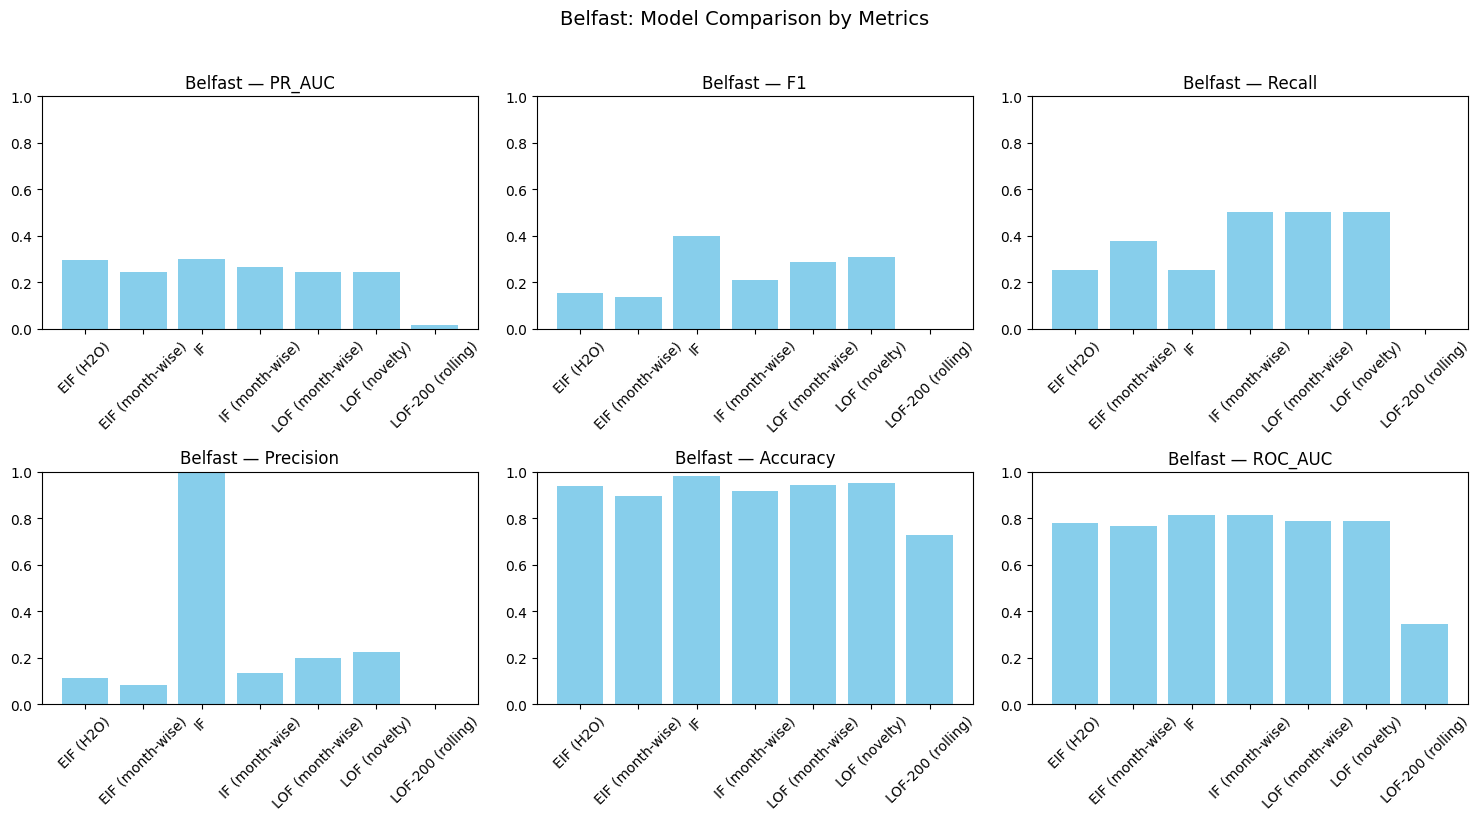

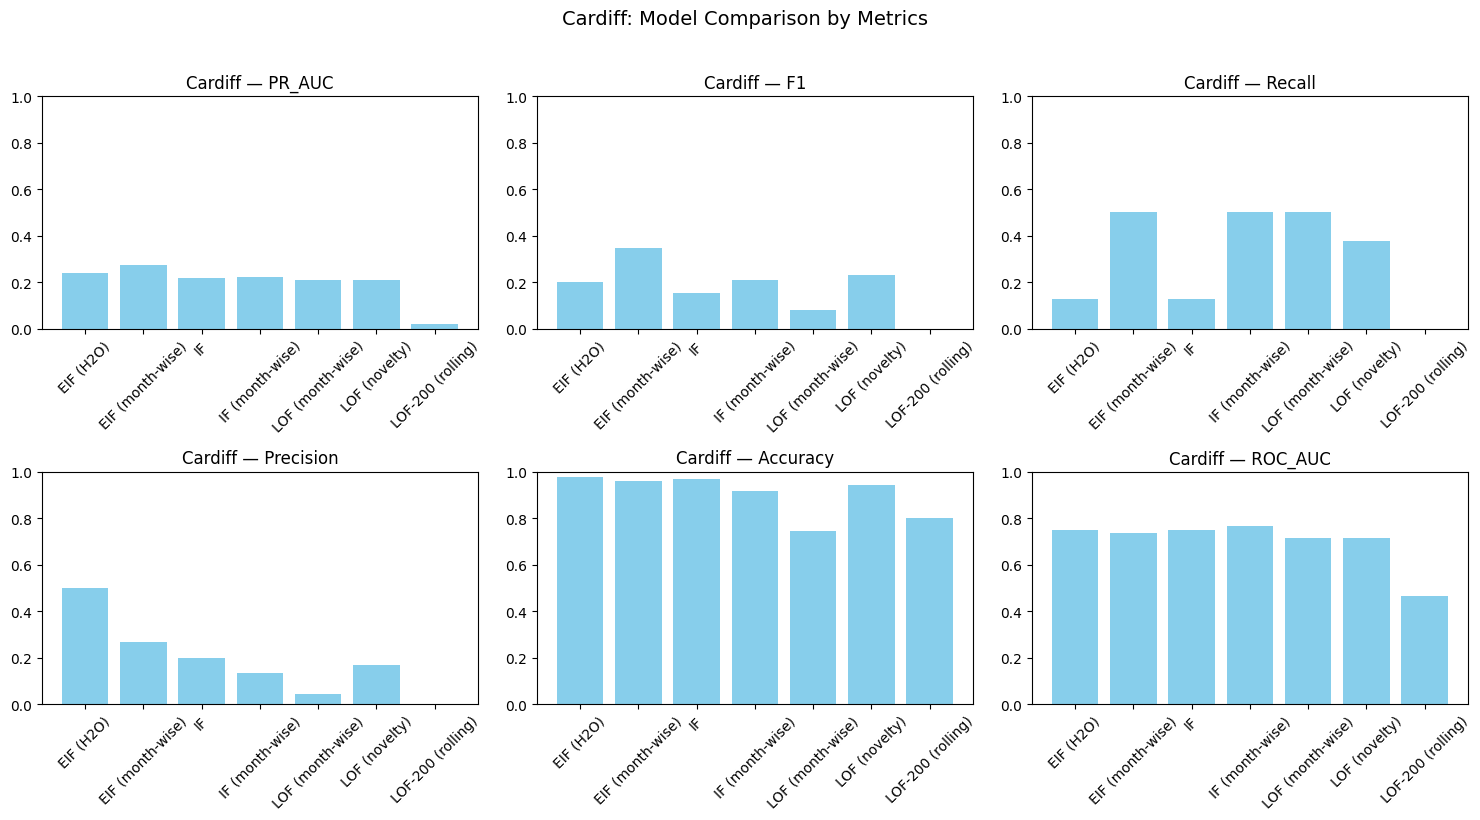

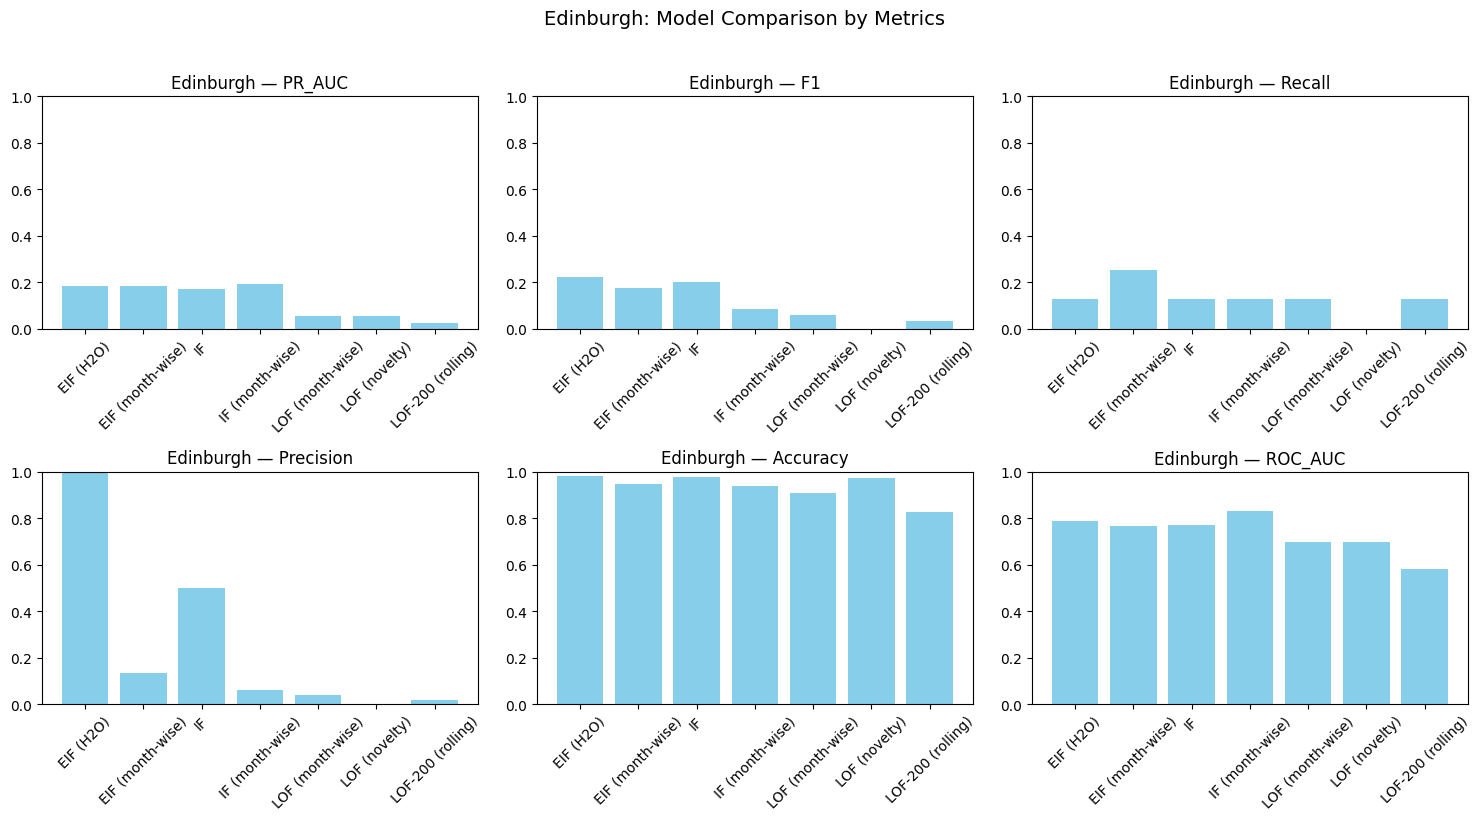

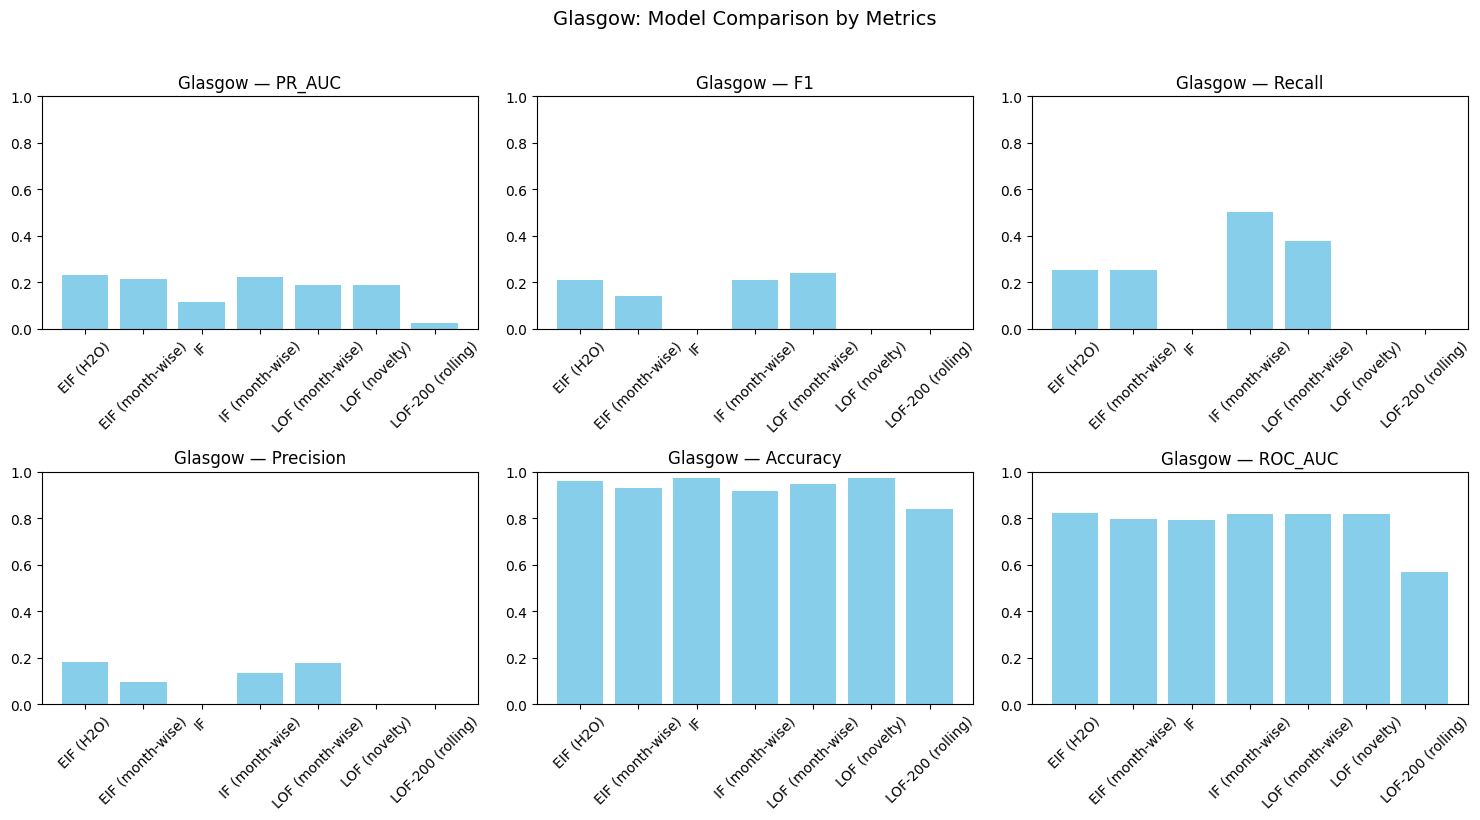

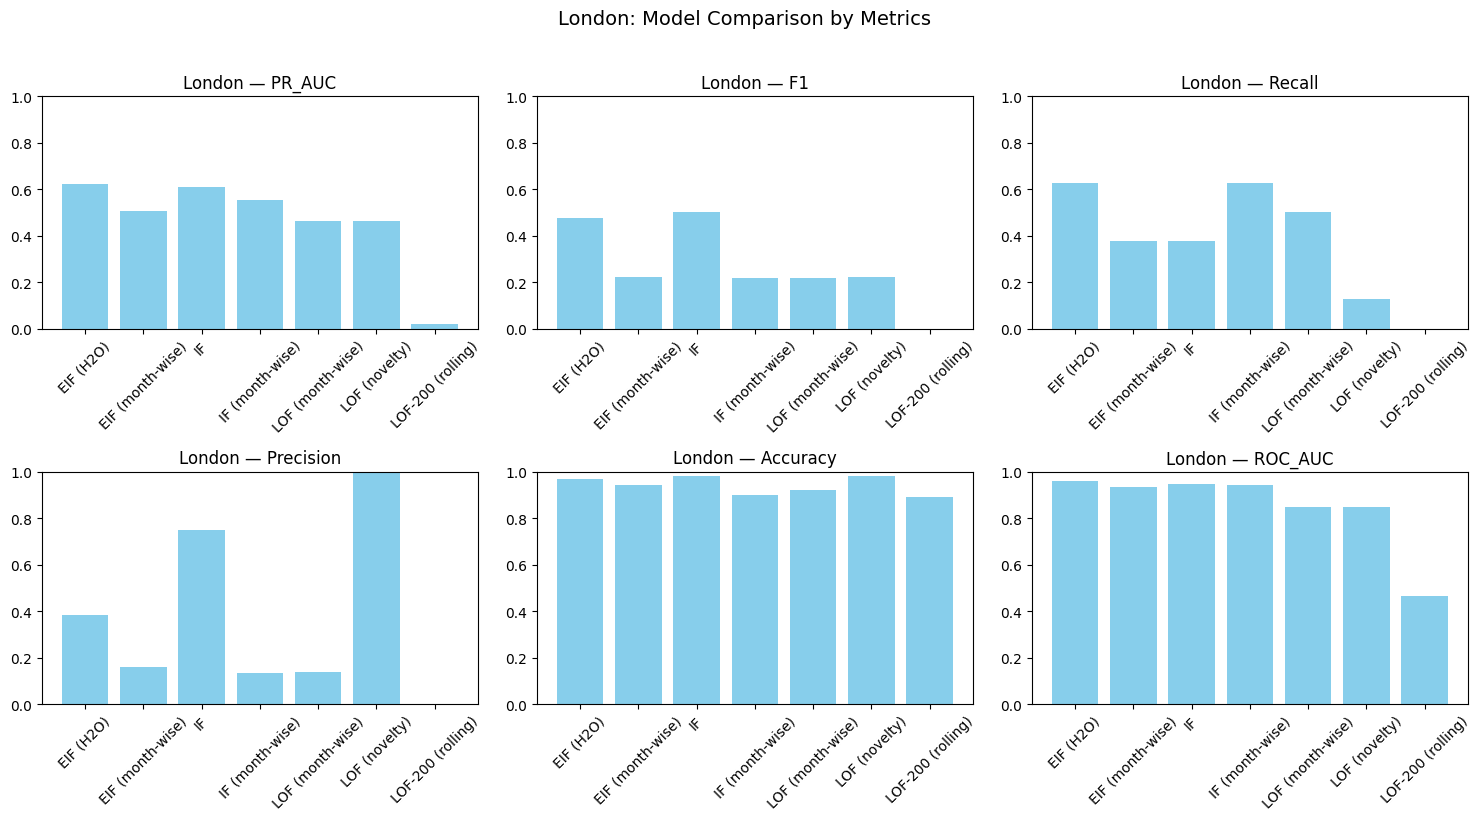

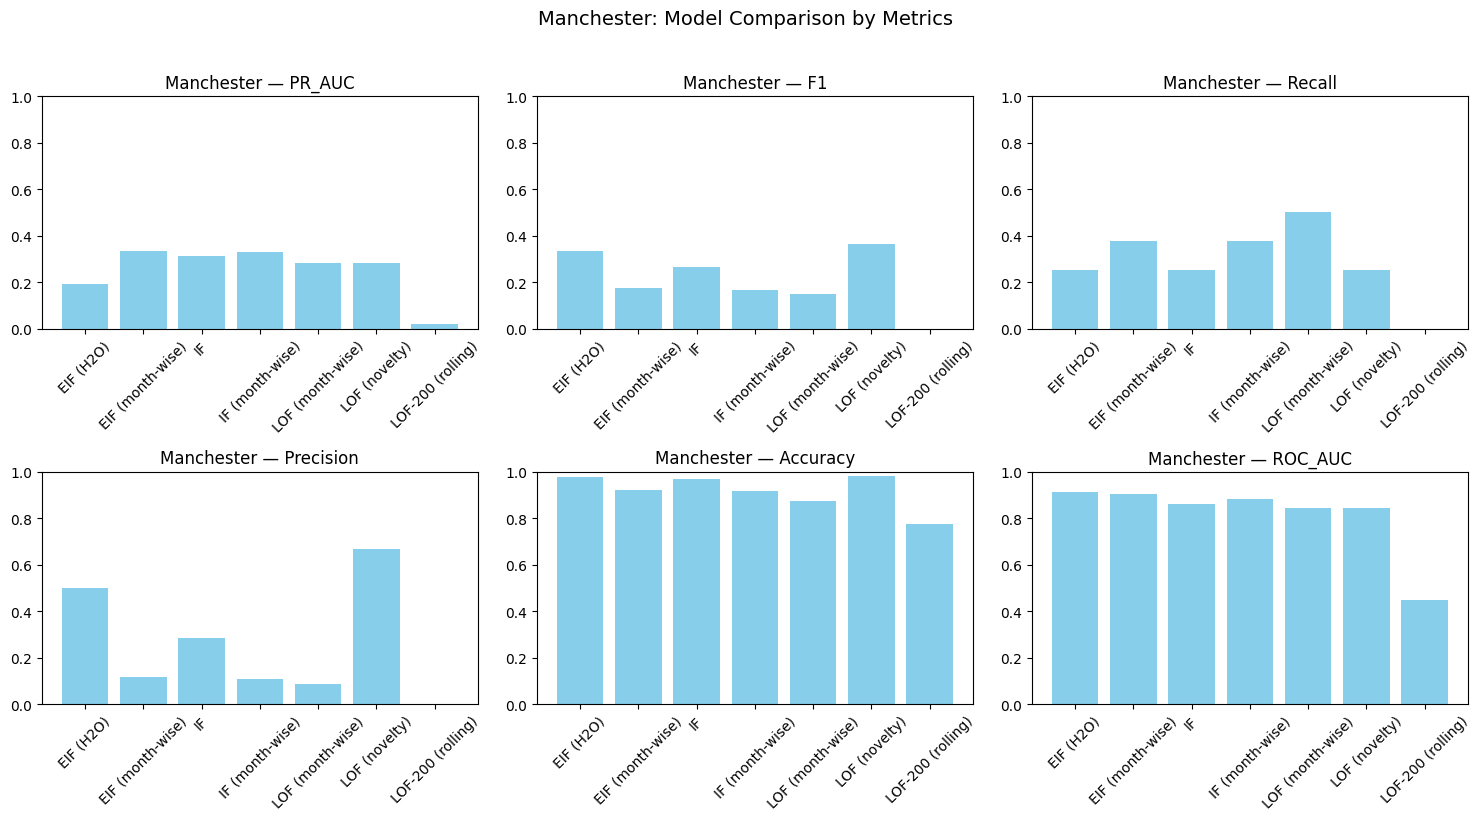

In [ ]:
import matplotlib.pyplot as plt

metrics_to_plot = ["PR_AUC","F1","Recall","Precision","Accuracy","ROC_AUC"]

for city in allResults["City"].unique():
    dfc = allResults[allResults["City"]==city]
    fig, axes = plt.subplots(2, 3, figsize=(15,8))
    axes = axes.flatten()
    for i, met in enumerate(metrics_to_plot):
        axes[i].bar(dfc["ModelVariant"], dfc[met], color="skyblue")
        axes[i].set_title(f"{city} — {met}")
        axes[i].set_ylim(0,1)
        axes[i].tick_params(axis="x", rotation=45)
    plt.suptitle(f"{city}: Model Comparison by Metrics", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()


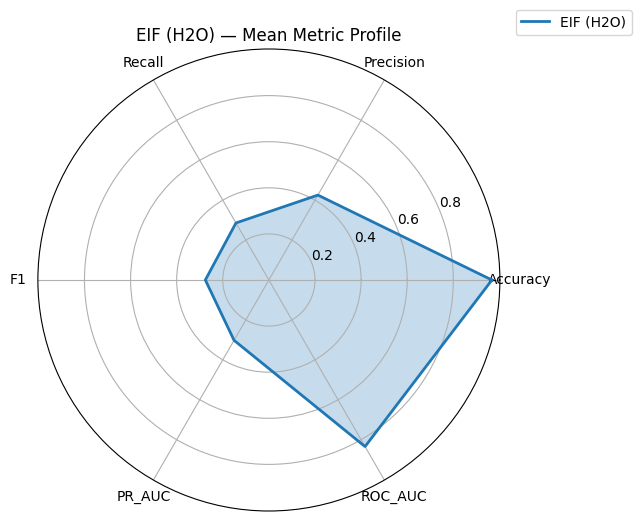

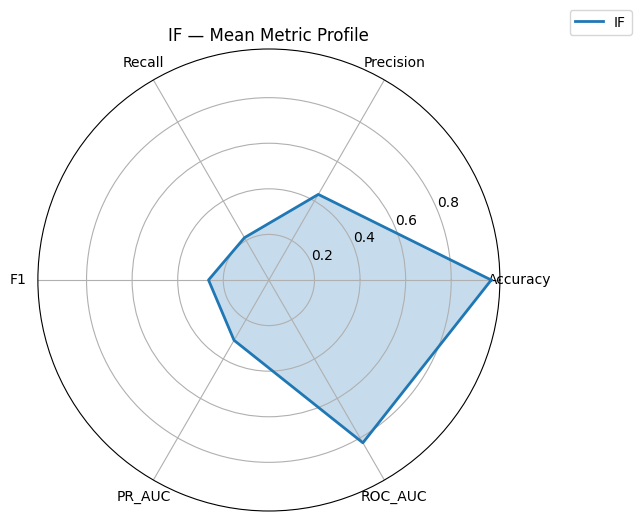

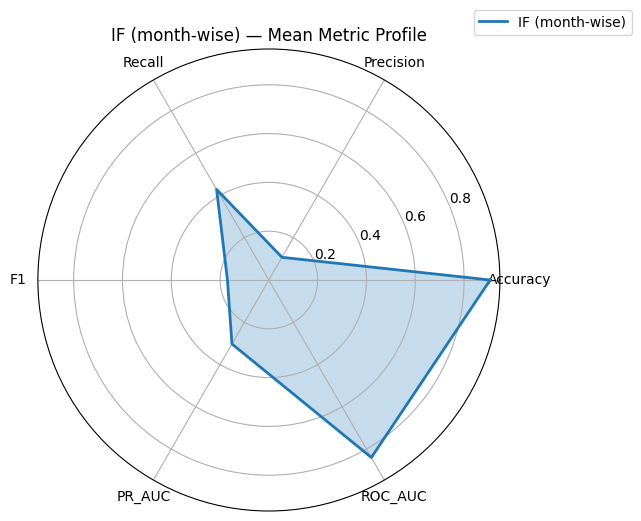

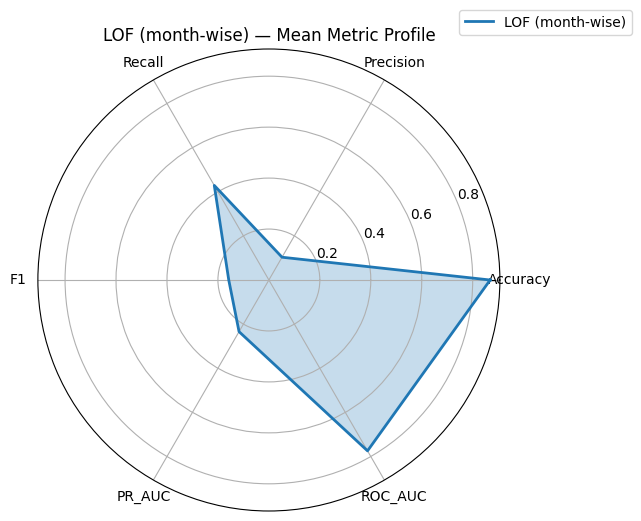

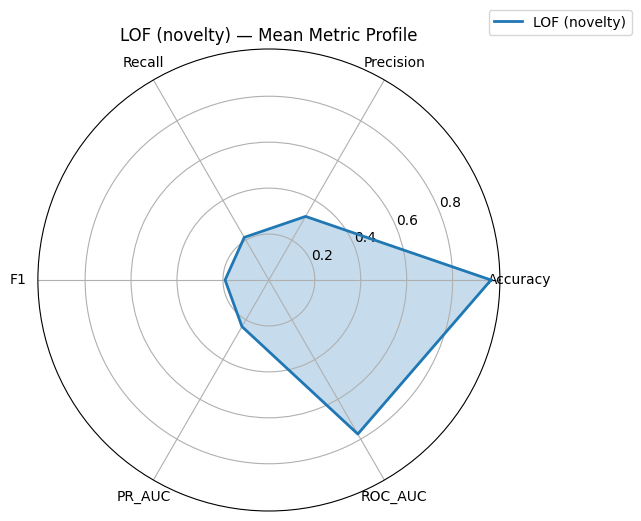

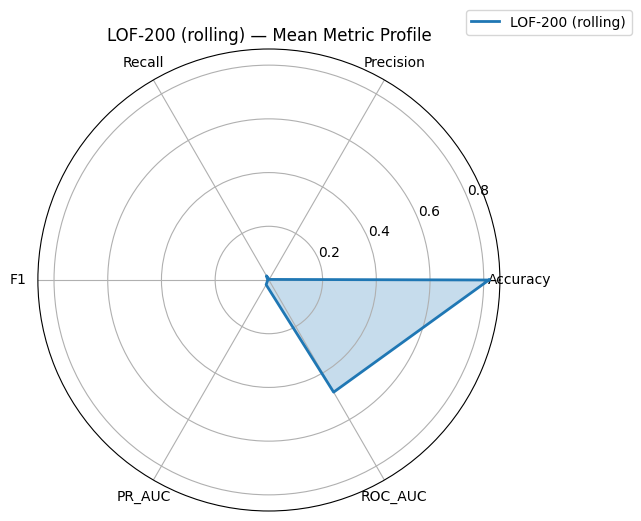

In [ ]:
import numpy as np

metrics_for_radar = ["Accuracy","Precision","Recall","F1","PR_AUC","ROC_AUC"]

models = allResults["ModelVariant"].unique()
for model in models:
    dfm = allResults[allResults["ModelVariant"]==model][metrics_for_radar].mean()
    values = dfm.values.flatten().tolist()
    values += values[:1]  # close the radar loop

    N = len(metrics_for_radar)
    angles = [n/float(N)*2*np.pi for n in range(N)]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=model)
    ax.fill(angles, values, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics_for_radar)
    ax.set_yticks([0.2,0.4,0.6,0.8])
    ax.set_title(f"{model} — Mean Metric Profile")
    plt.legend(loc="upper right", bbox_to_anchor=(1.3,1.1))
    plt.show()


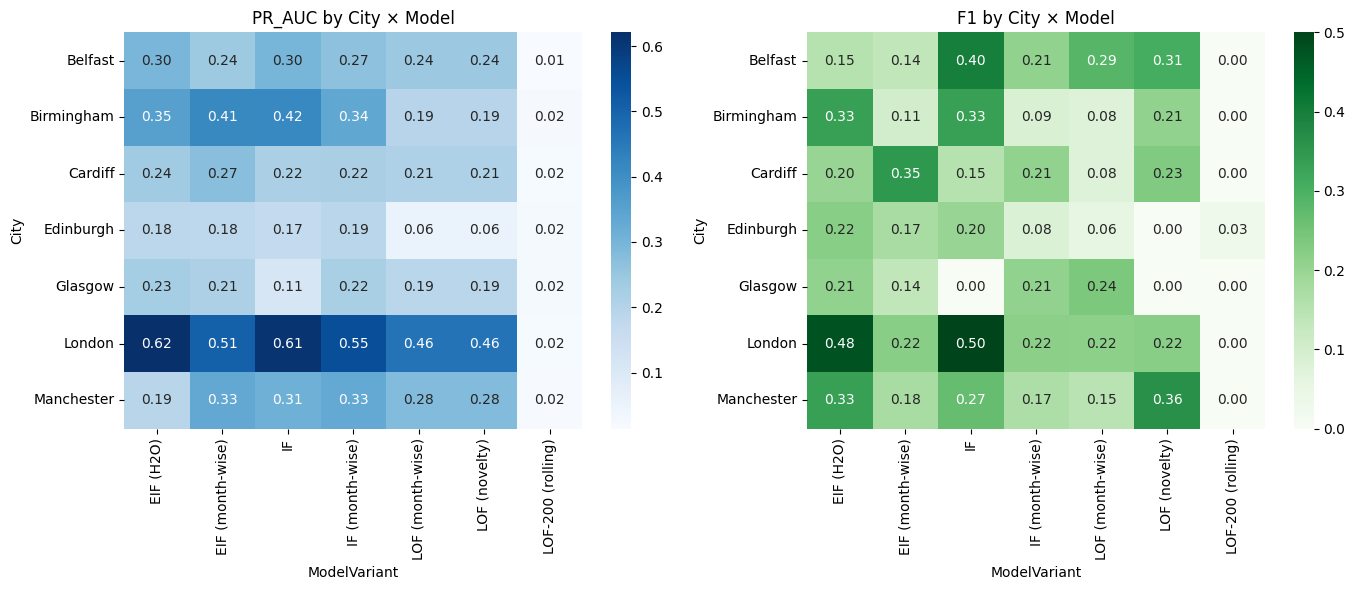

In [ ]:
import seaborn as sns

pivot_pr = allResults.pivot(index="City", columns="ModelVariant", values="PR_AUC")
pivot_f1 = allResults.pivot(index="City", columns="ModelVariant", values="F1")

fig, axes = plt.subplots(1,2, figsize=(14,6))
sns.heatmap(pivot_pr, annot=True, cmap="Blues", fmt=".2f", ax=axes[0])
axes[0].set_title("PR_AUC by City × Model")
sns.heatmap(pivot_f1, annot=True, cmap="Greens", fmt=".2f", ax=axes[1])
axes[1].set_title("F1 by City × Model")
plt.tight_layout()
plt.show()


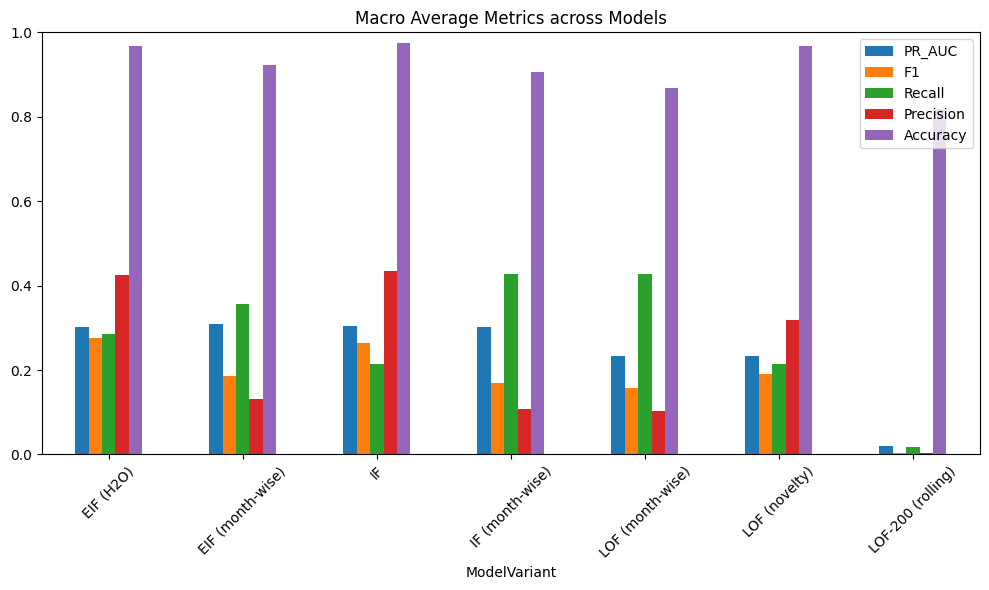

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
macroSummary.set_index("ModelVariant")[["PR_AUC","F1","Recall","Precision","Accuracy"]].plot.bar(ax=ax)
ax.set_ylim(0,1)
ax.set_title("Macro Average Metrics across Models")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
best_by_city = (
    allResults
    .sort_values(["City","PR_AUC","F1"], ascending=[True,False,False])
    .groupby("City")
    .first()[["ModelVariant","PR_AUC","F1"]]
    .reset_index()
)

print("Best model per city (by PR_AUC then F1):")
display(best_by_city)

fig, ax = plt.subplots(figsize=(8,6))
ax.barh(best_by_city["City"], best_by_city["PR_AUC"], color="orange")
for i, v in enumerate(best_by_city["ModelVariant"]):
    ax.text(best_by_city["PR_AUC"][i]+0.01, i, v, va="center")
ax.set_xlim(0,1)
ax.set_xlabel("PR_AUC")
ax.set_title("Best Model per City")
plt.tight_layout()
plt.show()


Best model per city (by PR_AUC then F1):


City      ModelVariant    PR_AUC        F1
0     Belfast                IF  0.300780  0.400000
1  Birmingham                IF  0.415156  0.333333
2     Cardiff  EIF (month-wise)  0.273726  0.347826
3   Edinburgh   IF (month-wise)  0.190446  0.083333
4     Glasgow         EIF (H2O)  0.228477  0.210526
5      London         EIF (H2O)  0.620926  0.476190
6  Manchester  EIF (month-wise)  0.332728  0.176471

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         3 hours 39 mins
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.7
H2O_cluster_version_age:    5 months and 2 days
H2O_cluster_name:           H2O_from_python_unknownUser_eqs89w
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    883 Mb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.12.11 final
--------------------------  -----------------------------------------------------------------------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


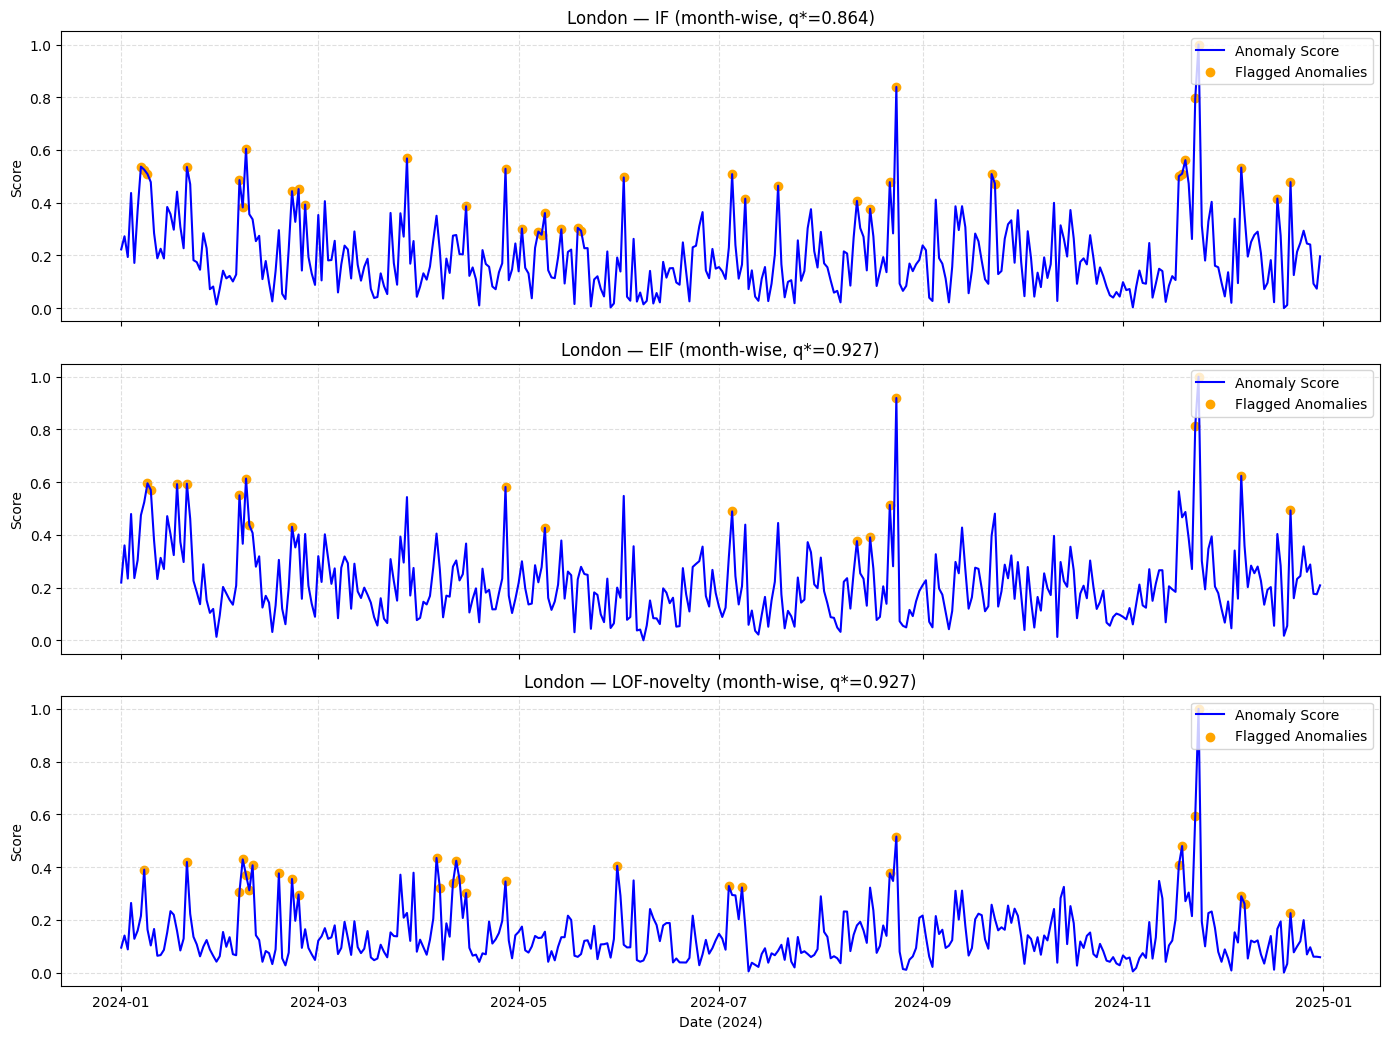

In [ ]:
plot_city_timelines( "London" , include_models=("IF","EIF","LOF-novelty"), prefer_monthwise=True)


Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         3 hours 37 mins
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.7
H2O_cluster_version_age:    5 months and 2 days
H2O_cluster_name:           H2O_from_python_unknownUser_eqs89w
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    970 Mb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.12.11 final
--------------------------  -----------------------------------------------------------------------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


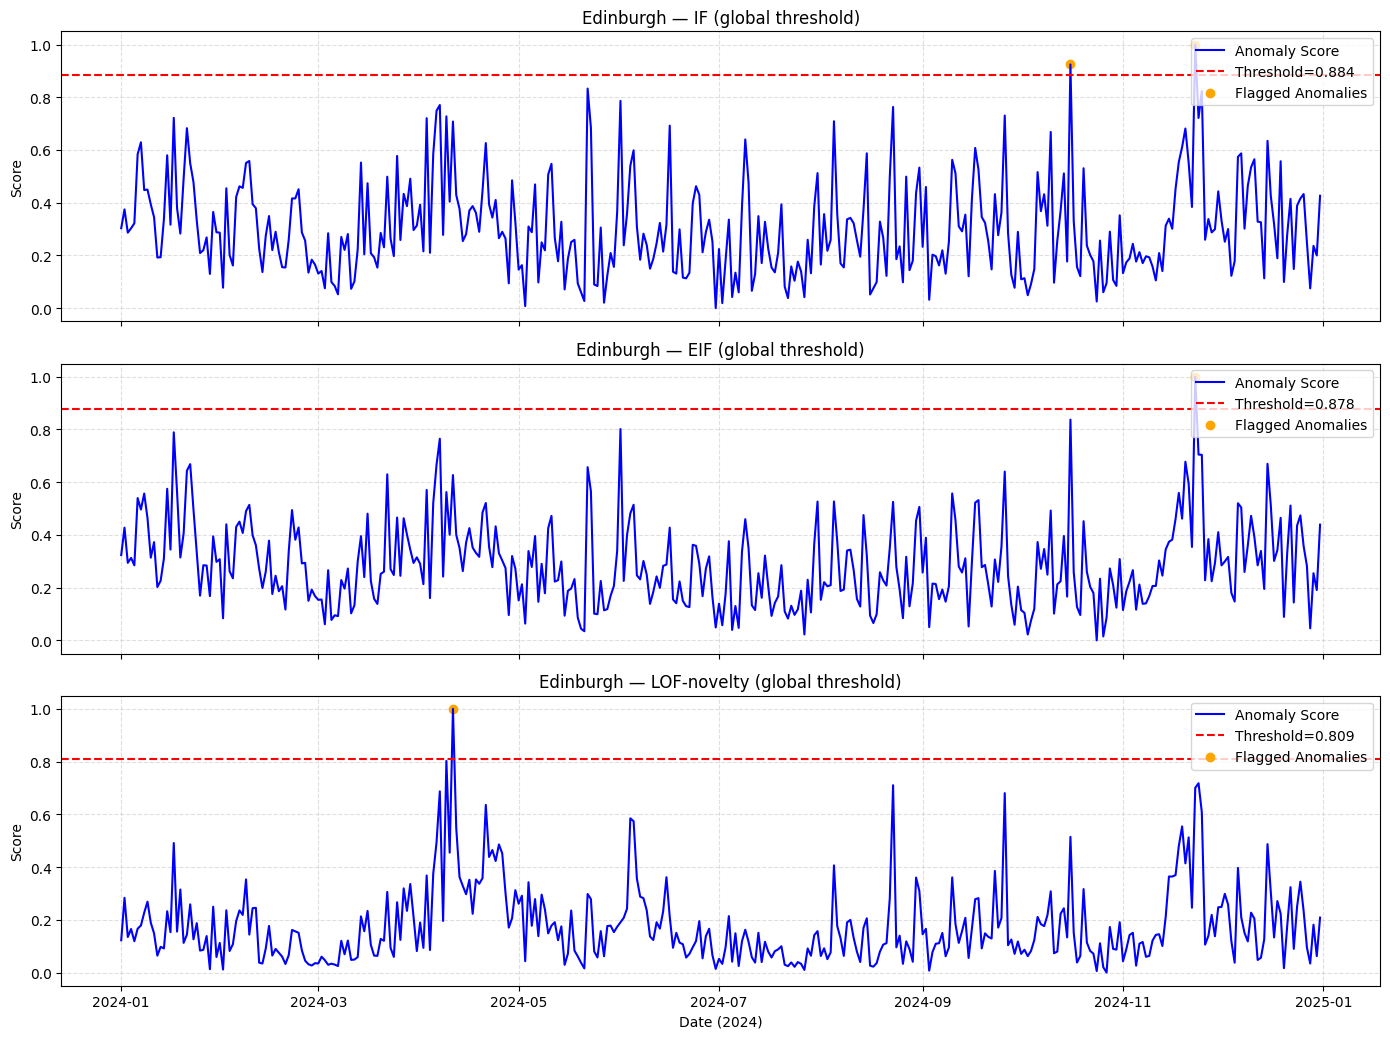

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         3 hours 37 mins
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.7
H2O_cluster_version_age:    5 months and 2 days
H2O_cluster_name:           H2O_from_python_unknownUser_eqs89w
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    932 Mb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.12.11 final
--------------------------  -----------------------------------------------------------------------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         3 hours 37 mins
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.7
H2O_cluster_version_age:    5 months and 2 days
H2O_cluster_name:           H2O_from_python_unknownUser_eqs89w
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    984 Mb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.12.11 final
--------------------------  -----------------------------------------------------------------------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


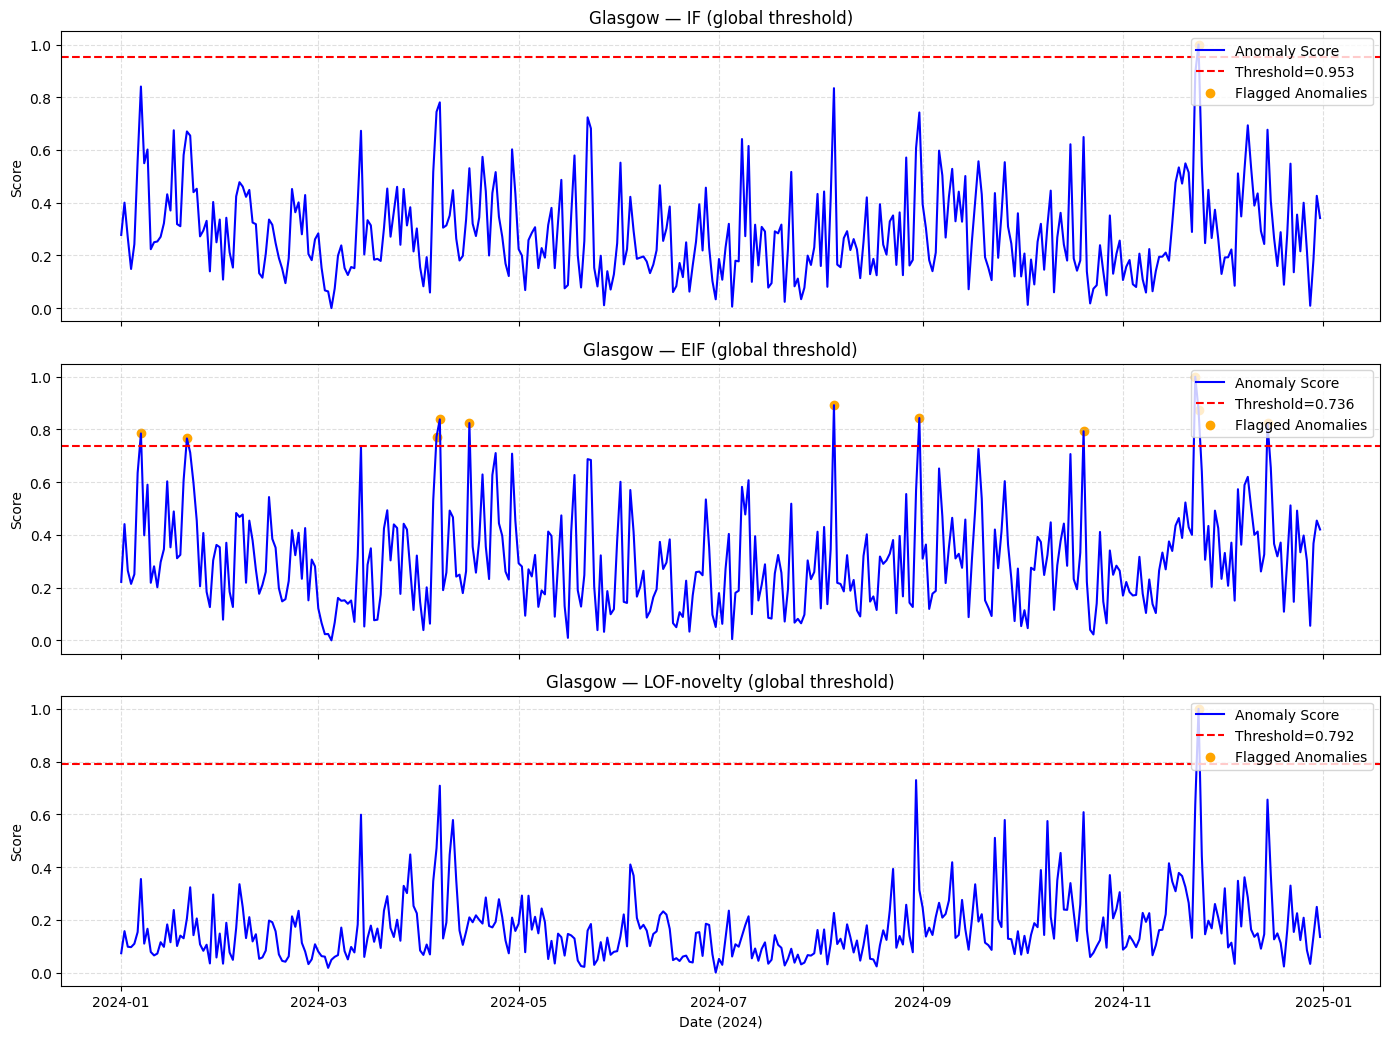

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         3 hours 37 mins
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.7
H2O_cluster_version_age:    5 months and 2 days
H2O_cluster_name:           H2O_from_python_unknownUser_eqs89w
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    967 Mb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.12.11 final
--------------------------  -----------------------------------------------------------------------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


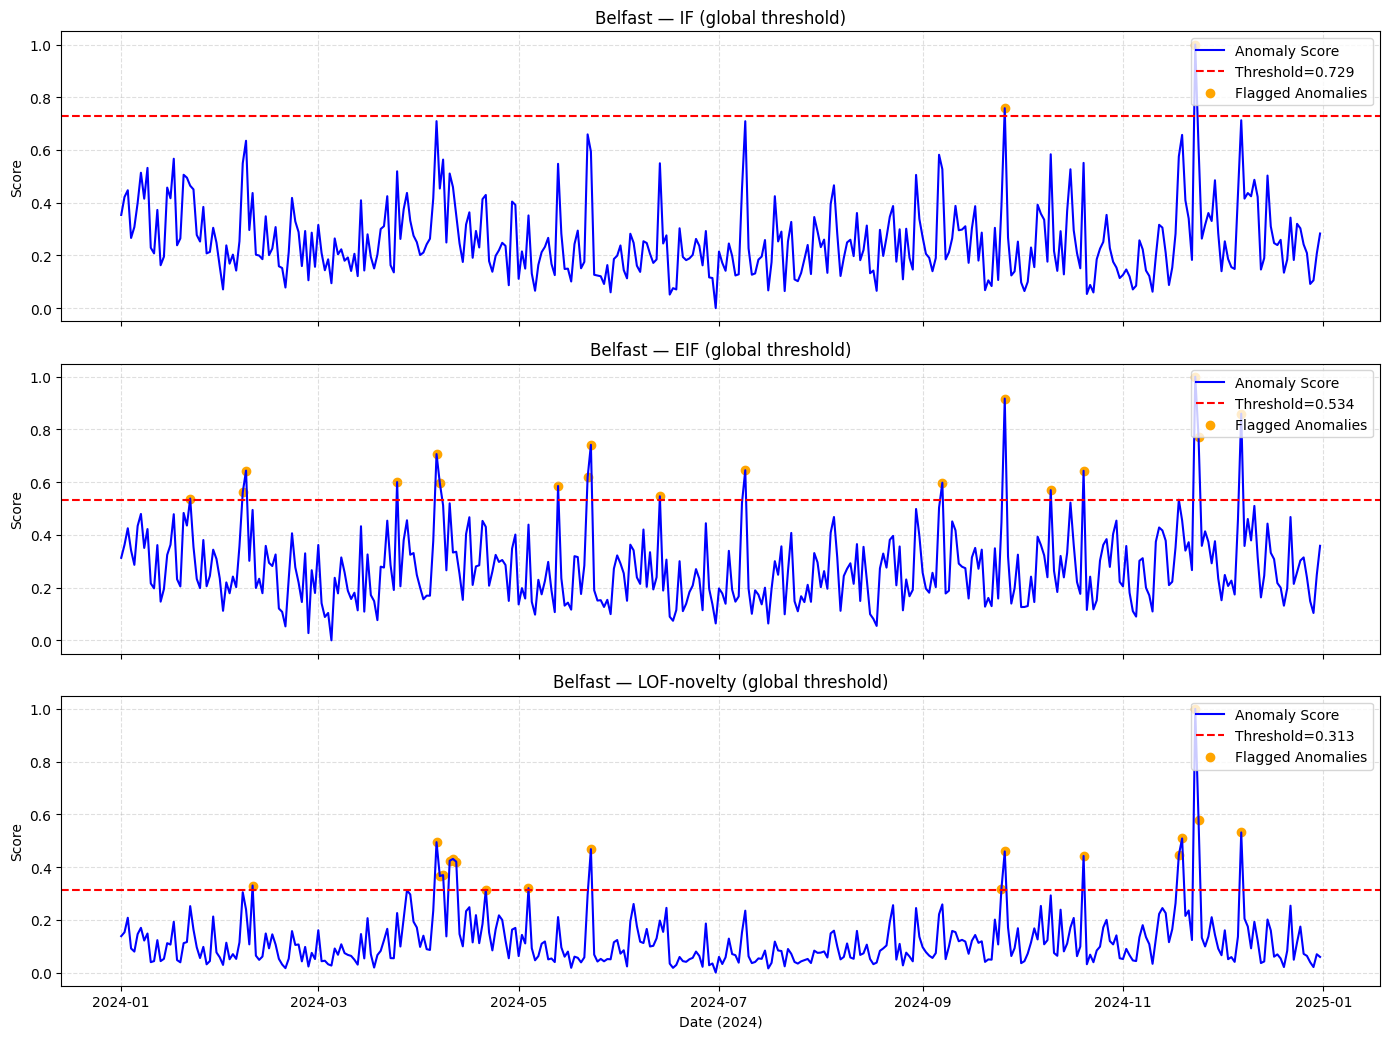

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         3 hours 37 mins
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.7
H2O_cluster_version_age:    5 months and 2 days
H2O_cluster_name:           H2O_from_python_unknownUser_eqs89w
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    959 Mb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.12.11 final
--------------------------  -----------------------------------------------------------------------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


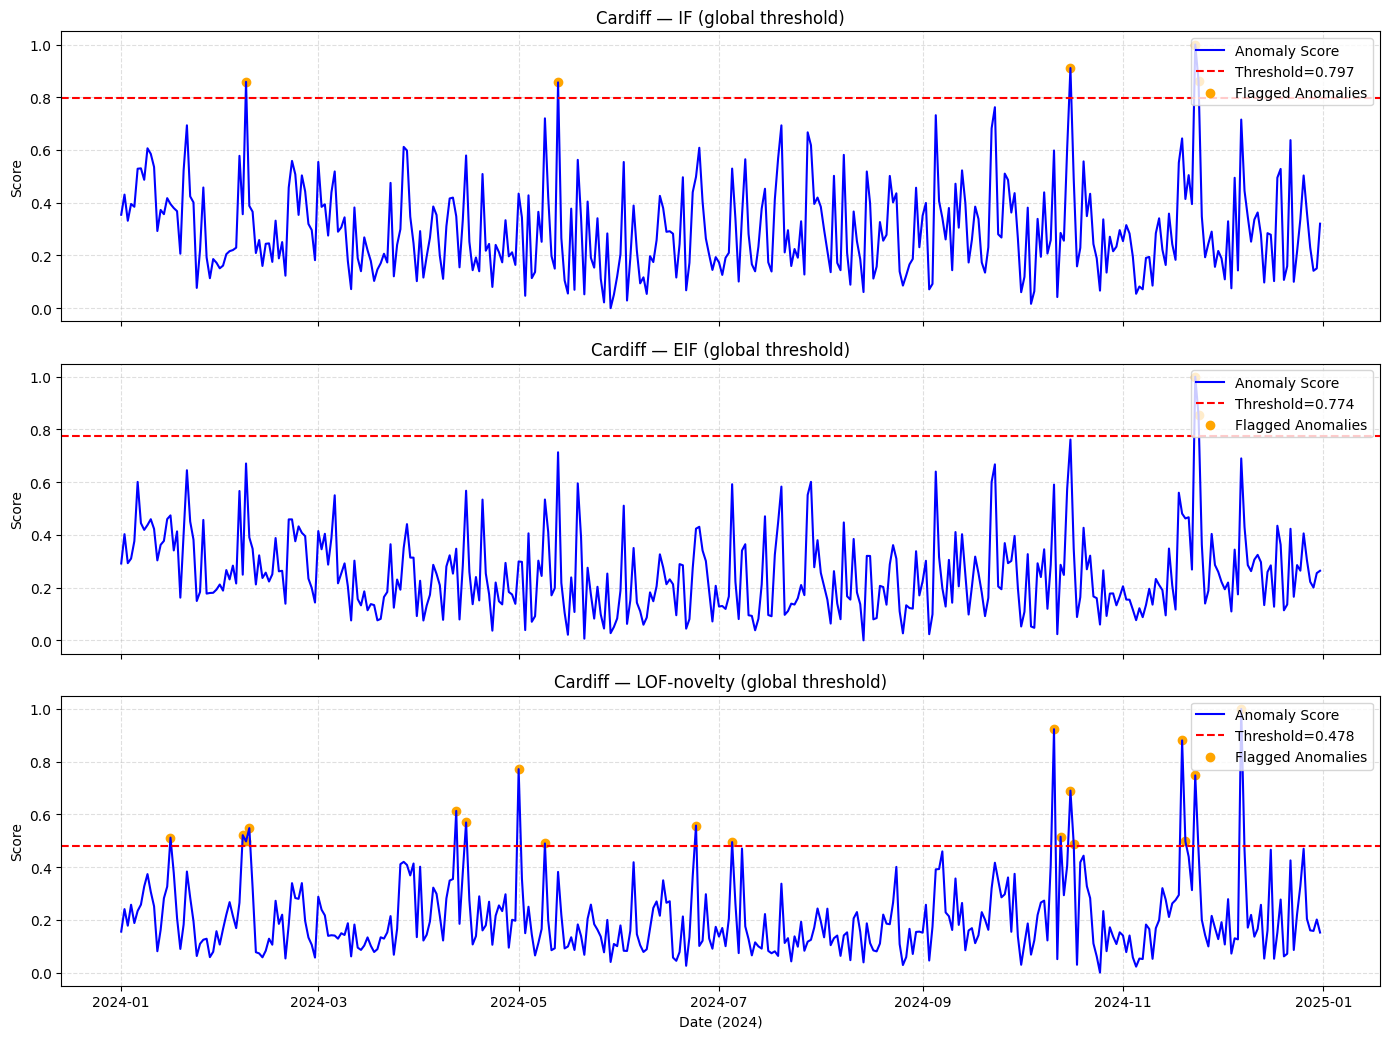

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         3 hours 37 mins
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.7
H2O_cluster_version_age:    5 months and 2 days
H2O_cluster_name:           H2O_from_python_unknownUser_eqs89w
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    951 Mb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.12.11 final
--------------------------  -----------------------------------------------------------------------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


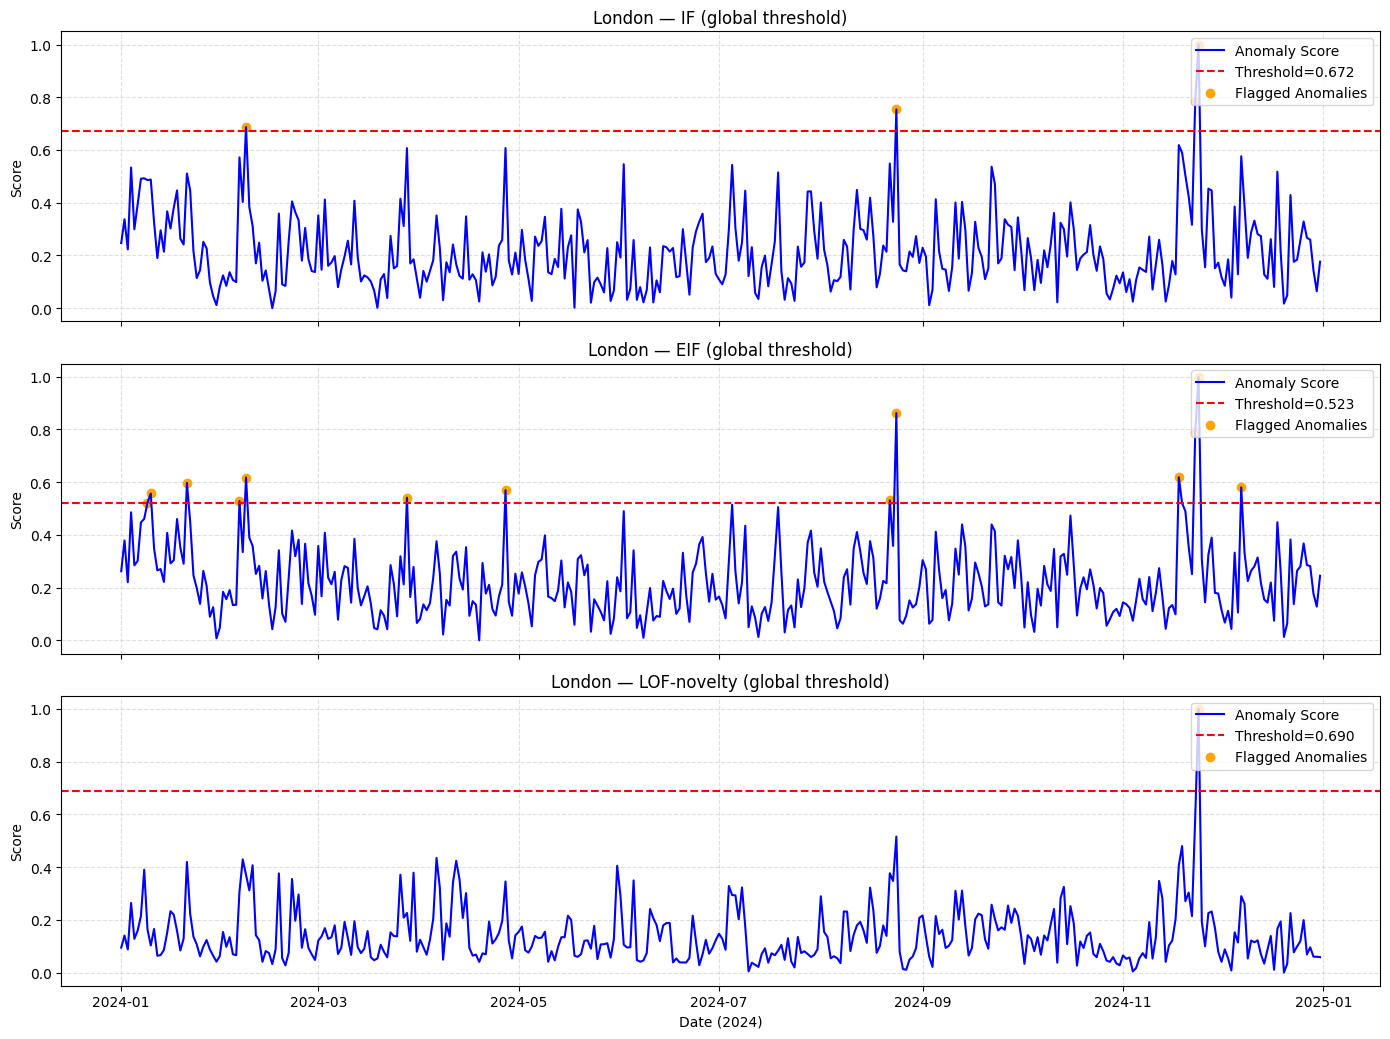

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         3 hours 37 mins
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.7
H2O_cluster_version_age:    5 months and 2 days
H2O_cluster_name:           H2O_from_python_unknownUser_eqs89w
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    914 Mb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.12.11 final
--------------------------  -----------------------------------------------------------------------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


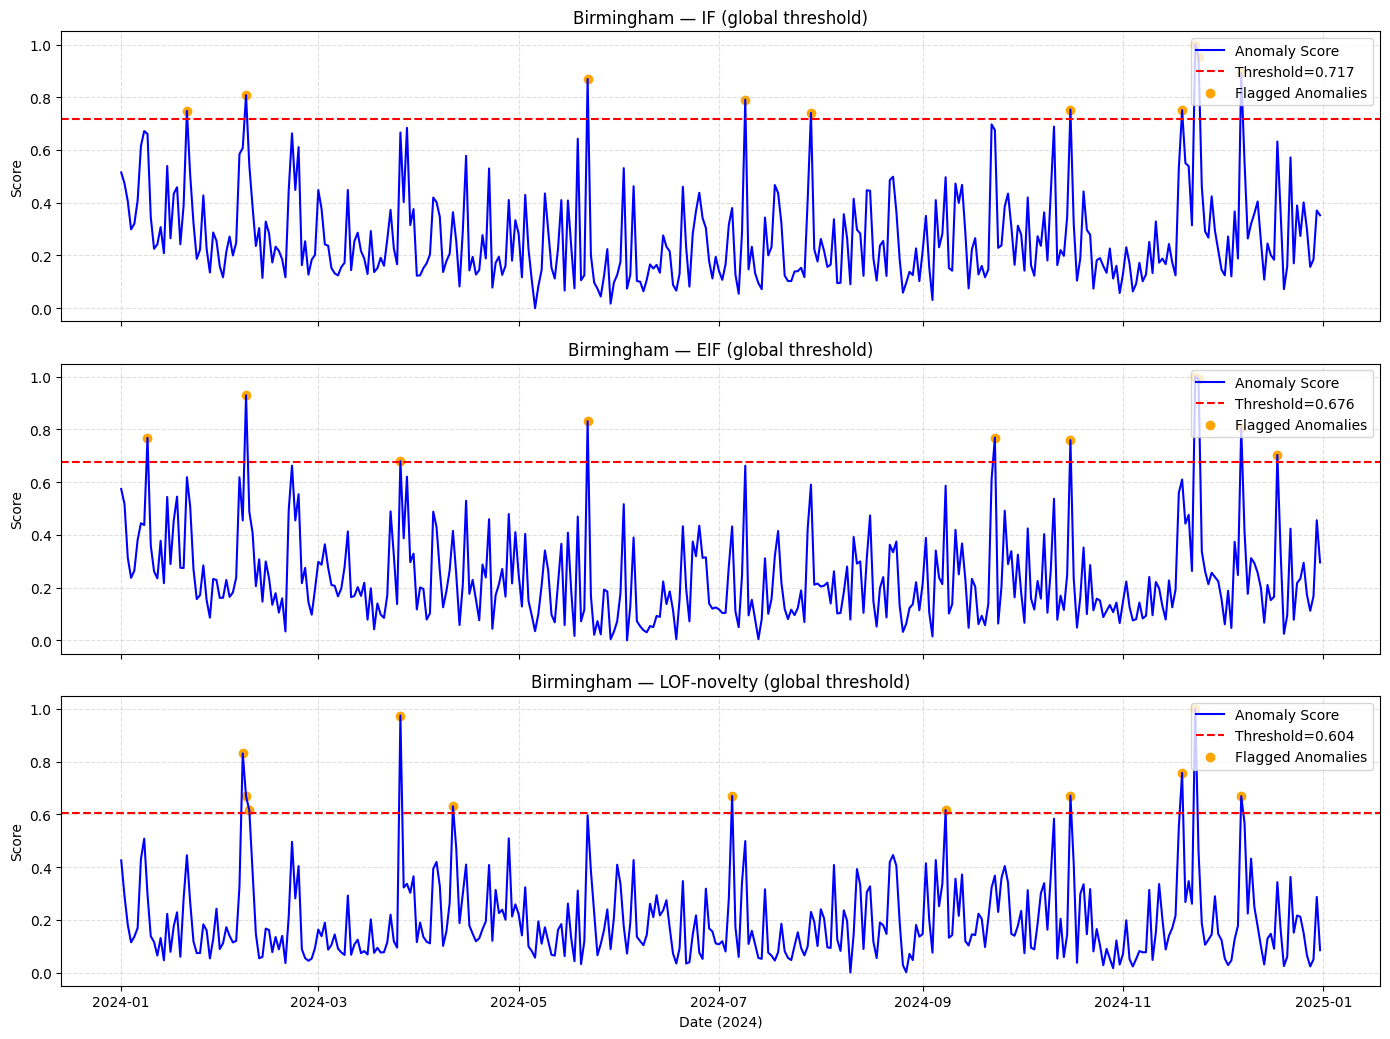

In [ ]:
for c in cities:
    plot_city_timelines(c, include_models=("IF","EIF","LOF-novelty"), prefer_monthwise=False)


In [ ]:
assert 'allResults' in globals(), "Run the unified comparison cell first to create allResults."
cities_list = sorted(allResults['City'].unique().tolist())
models_list = sorted(allResults['ModelVariant'].unique().tolist())
print("Cities:", cities_list)
print("Models:", models_list)


Cities: ['Belfast', 'Birmingham', 'Cardiff', 'Edinburgh', 'Glasgow', 'London', 'Manchester']
Models: ['EIF (H2O)', 'EIF (month-wise)', 'IF', 'IF (month-wise)', 'LOF (month-wise)', 'LOF (novelty)', 'LOF-200 (rolling)']


/tmp/ipython-input-3317167248.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(cities, rotation=45, ha="right"); ax4.grid(True, alpha=.2)


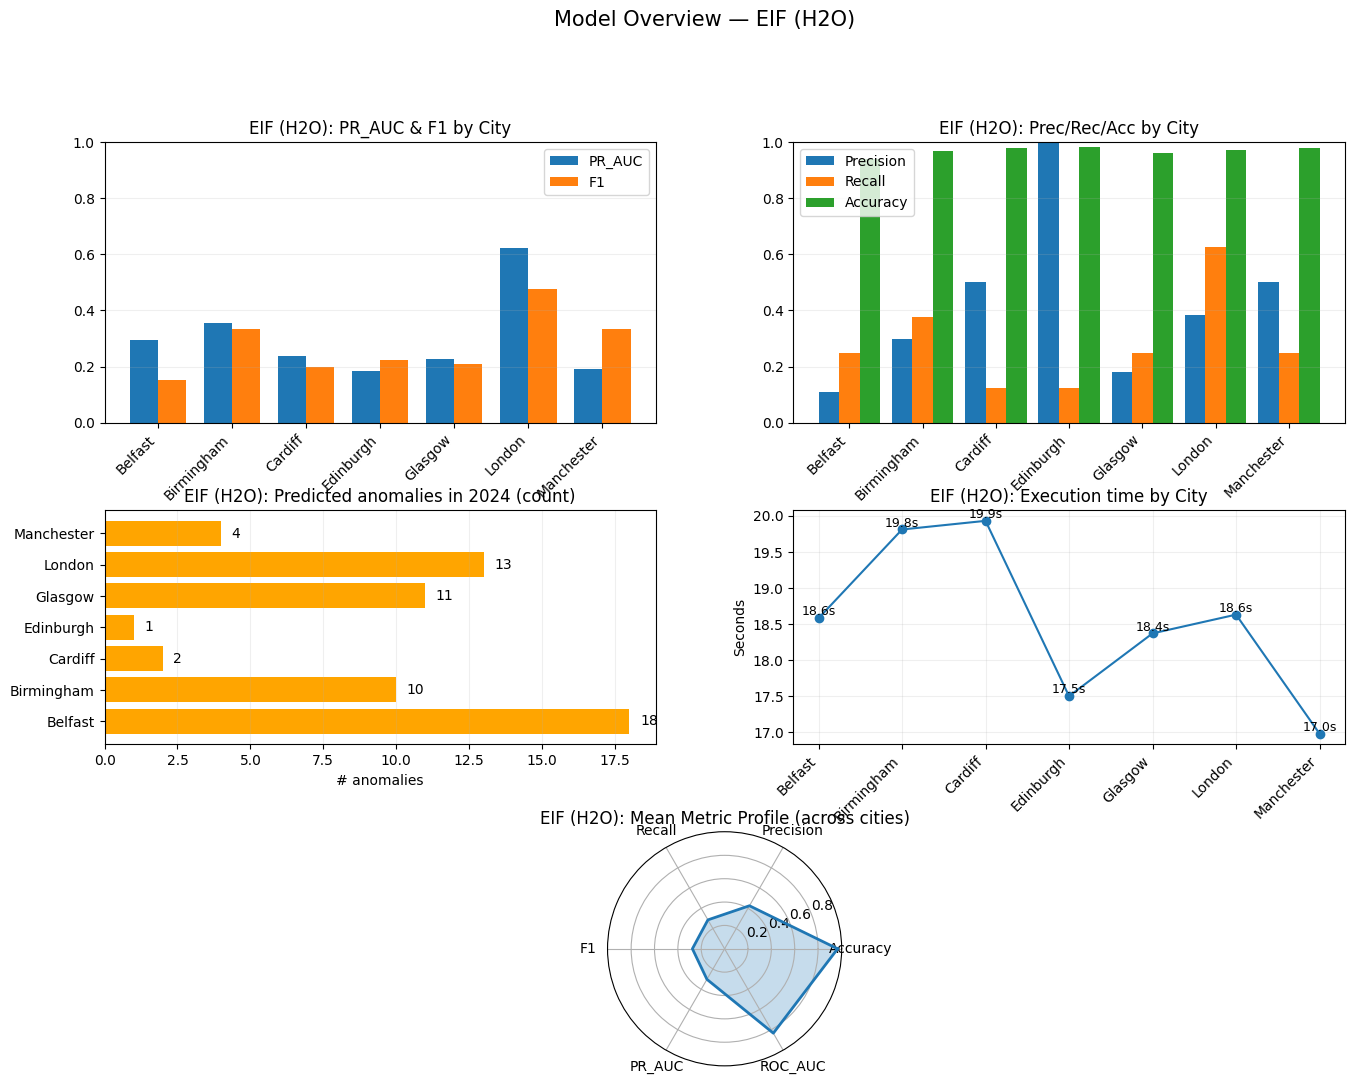

/tmp/ipython-input-3317167248.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(cities, rotation=45, ha="right"); ax4.grid(True, alpha=.2)


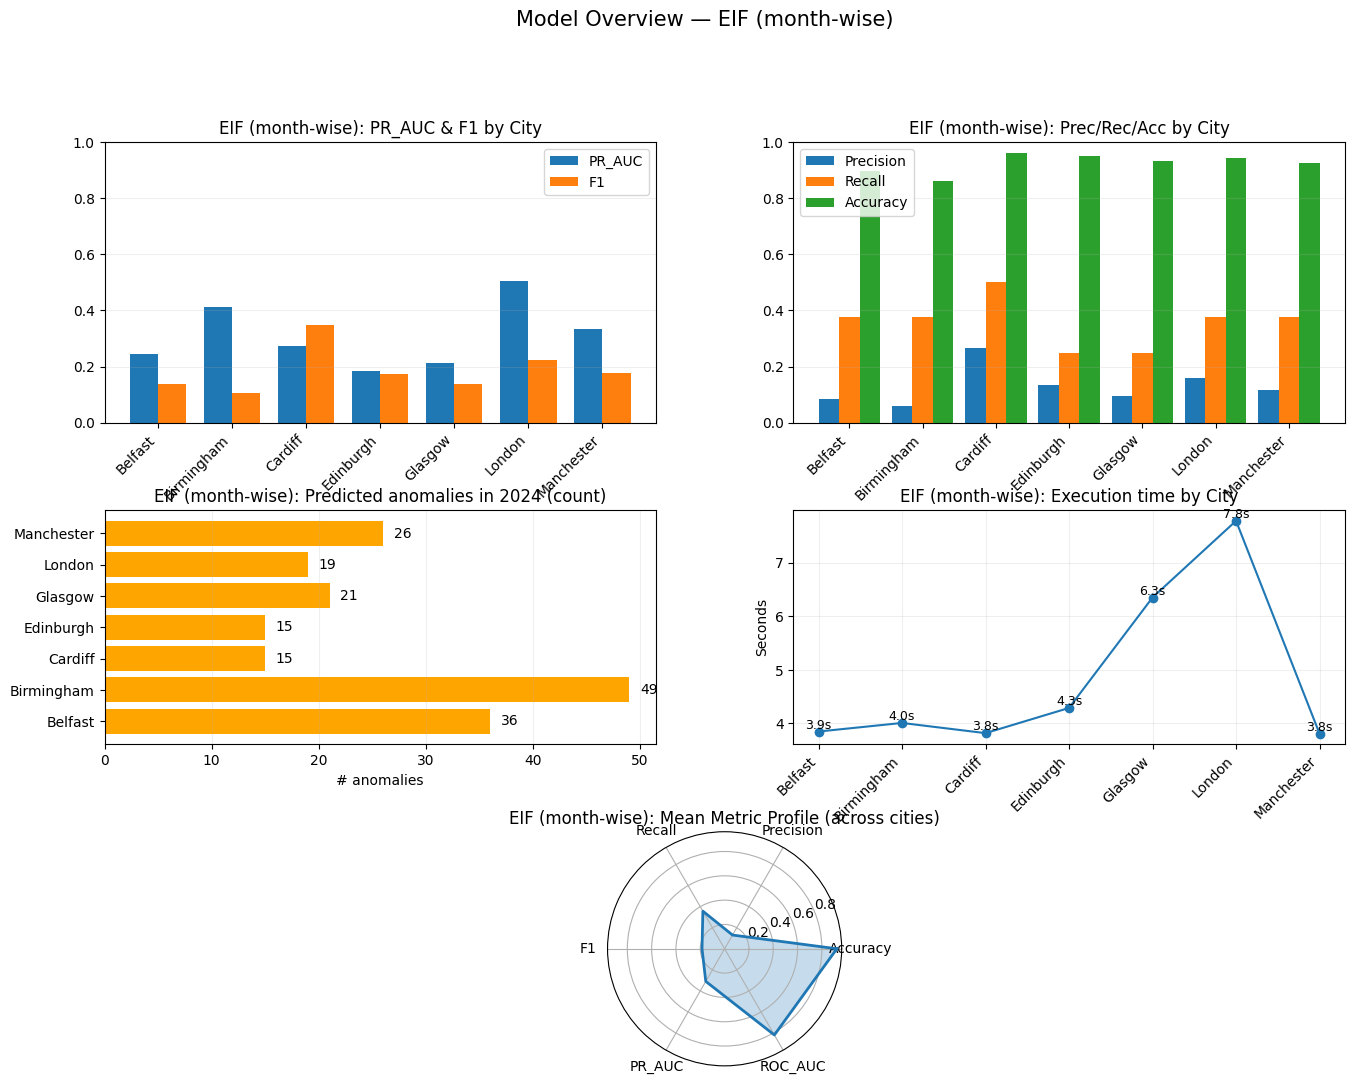

/tmp/ipython-input-3317167248.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(cities, rotation=45, ha="right"); ax4.grid(True, alpha=.2)


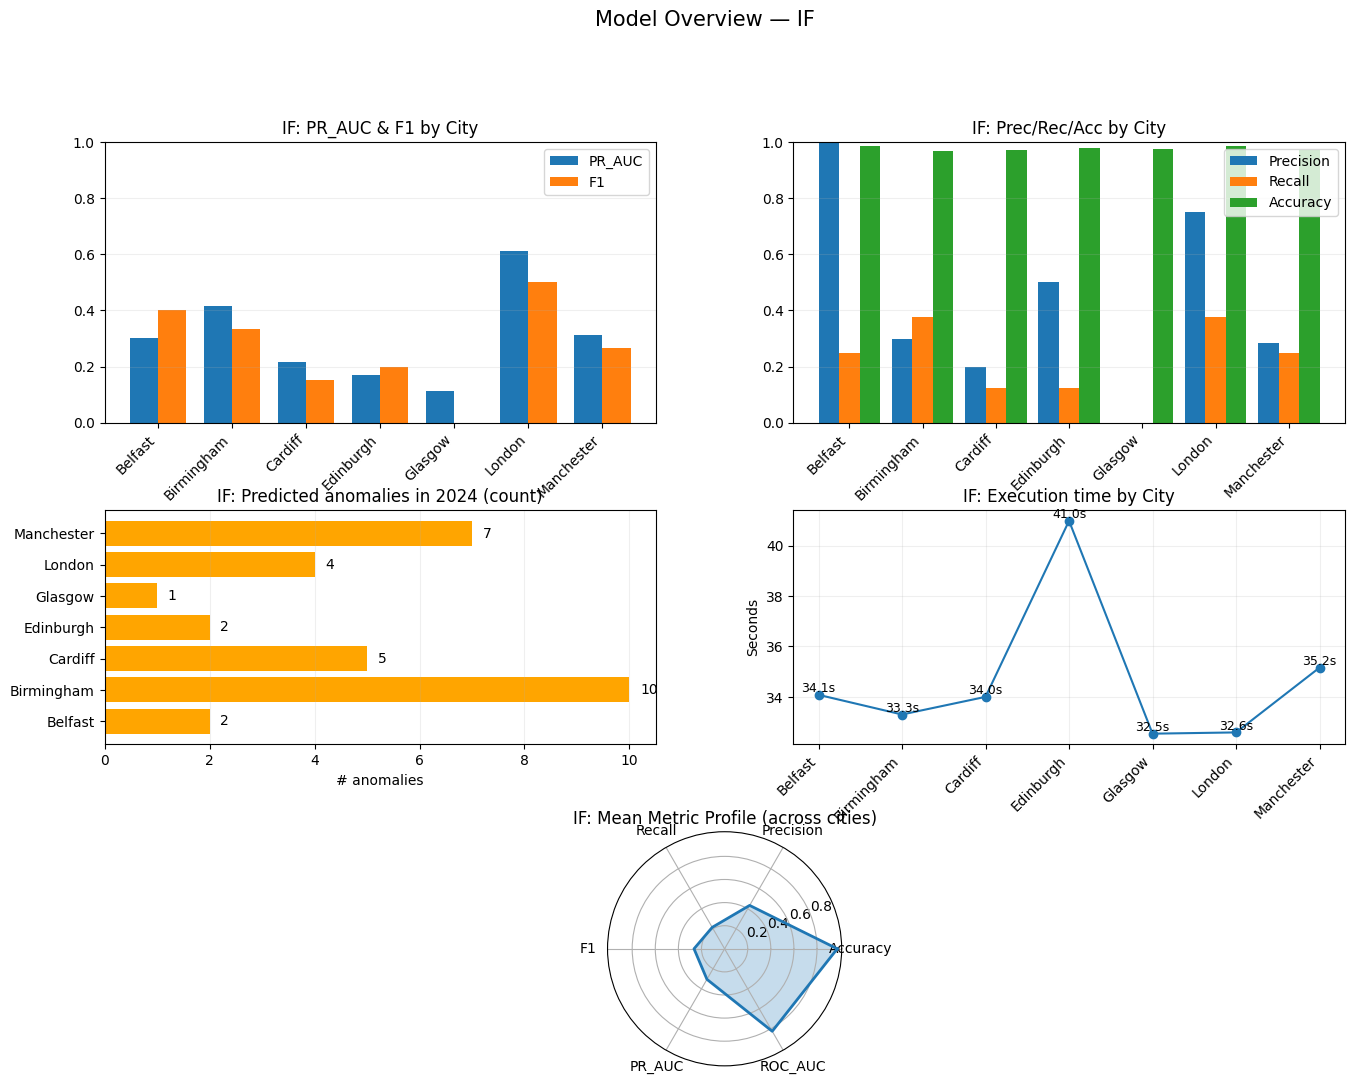

/tmp/ipython-input-3317167248.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(cities, rotation=45, ha="right"); ax4.grid(True, alpha=.2)


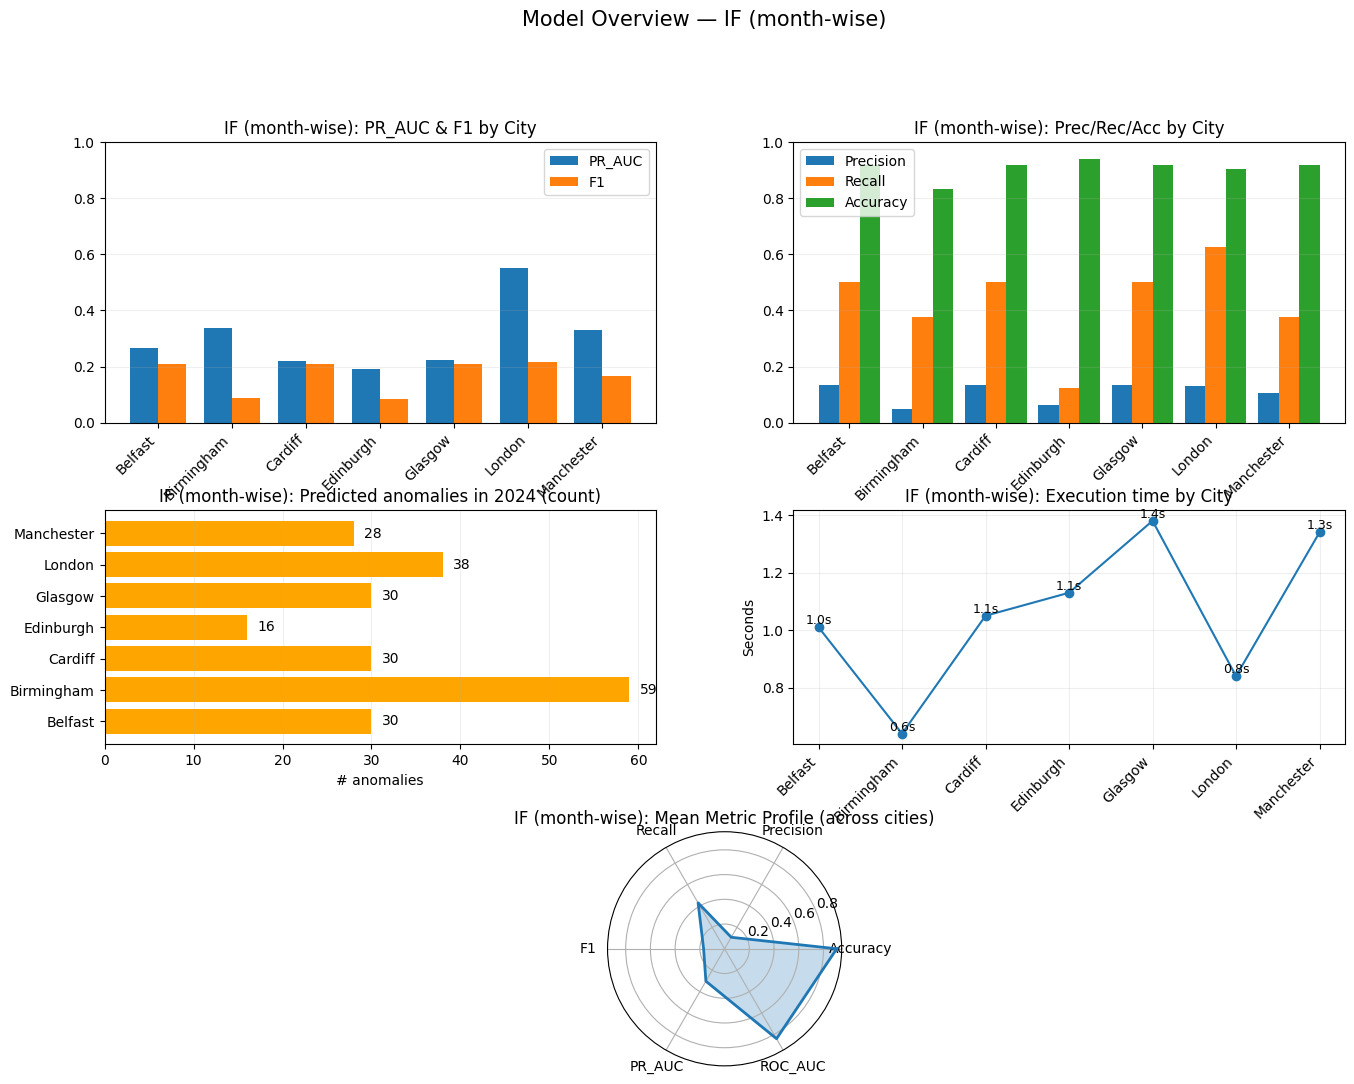

/tmp/ipython-input-3317167248.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(cities, rotation=45, ha="right"); ax4.grid(True, alpha=.2)


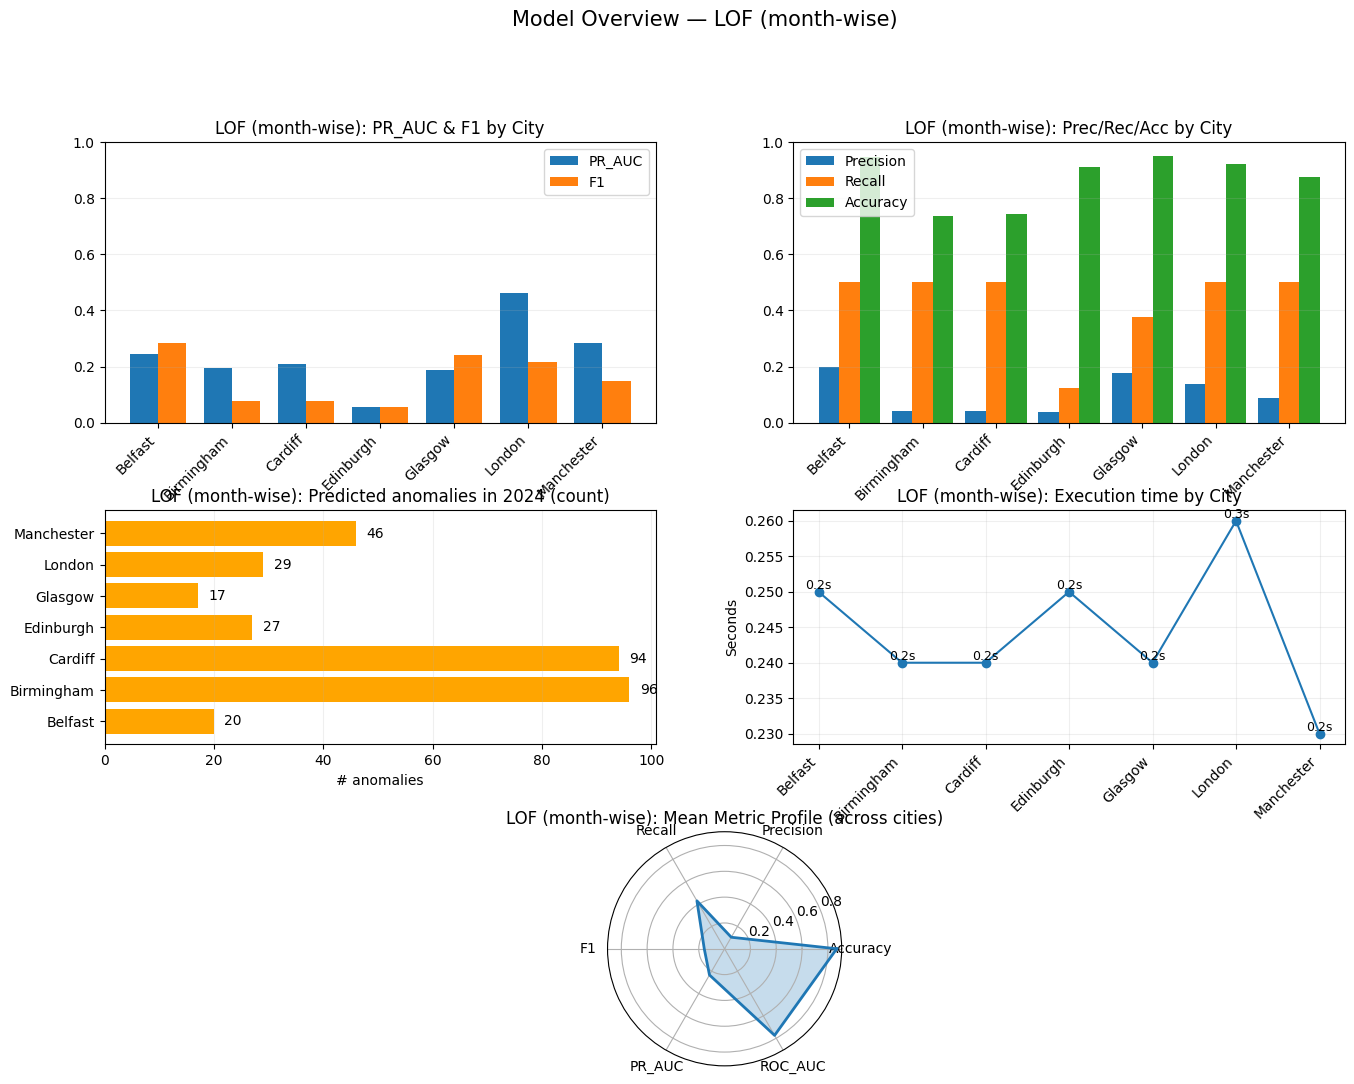

/tmp/ipython-input-3317167248.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(cities, rotation=45, ha="right"); ax4.grid(True, alpha=.2)


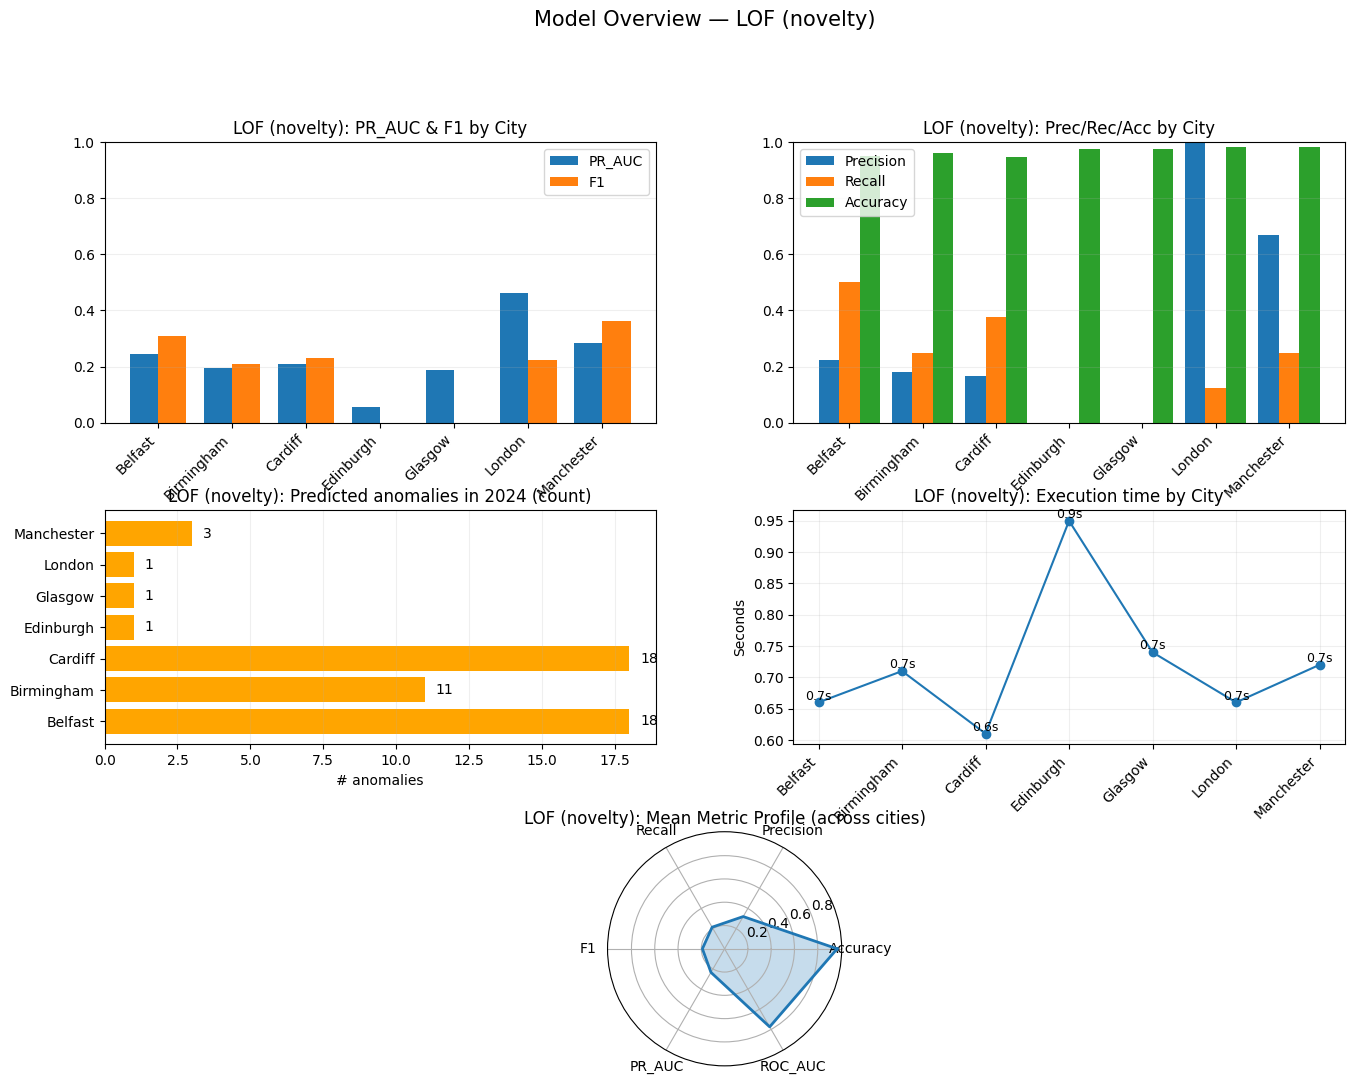

/tmp/ipython-input-3317167248.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(cities, rotation=45, ha="right"); ax4.grid(True, alpha=.2)


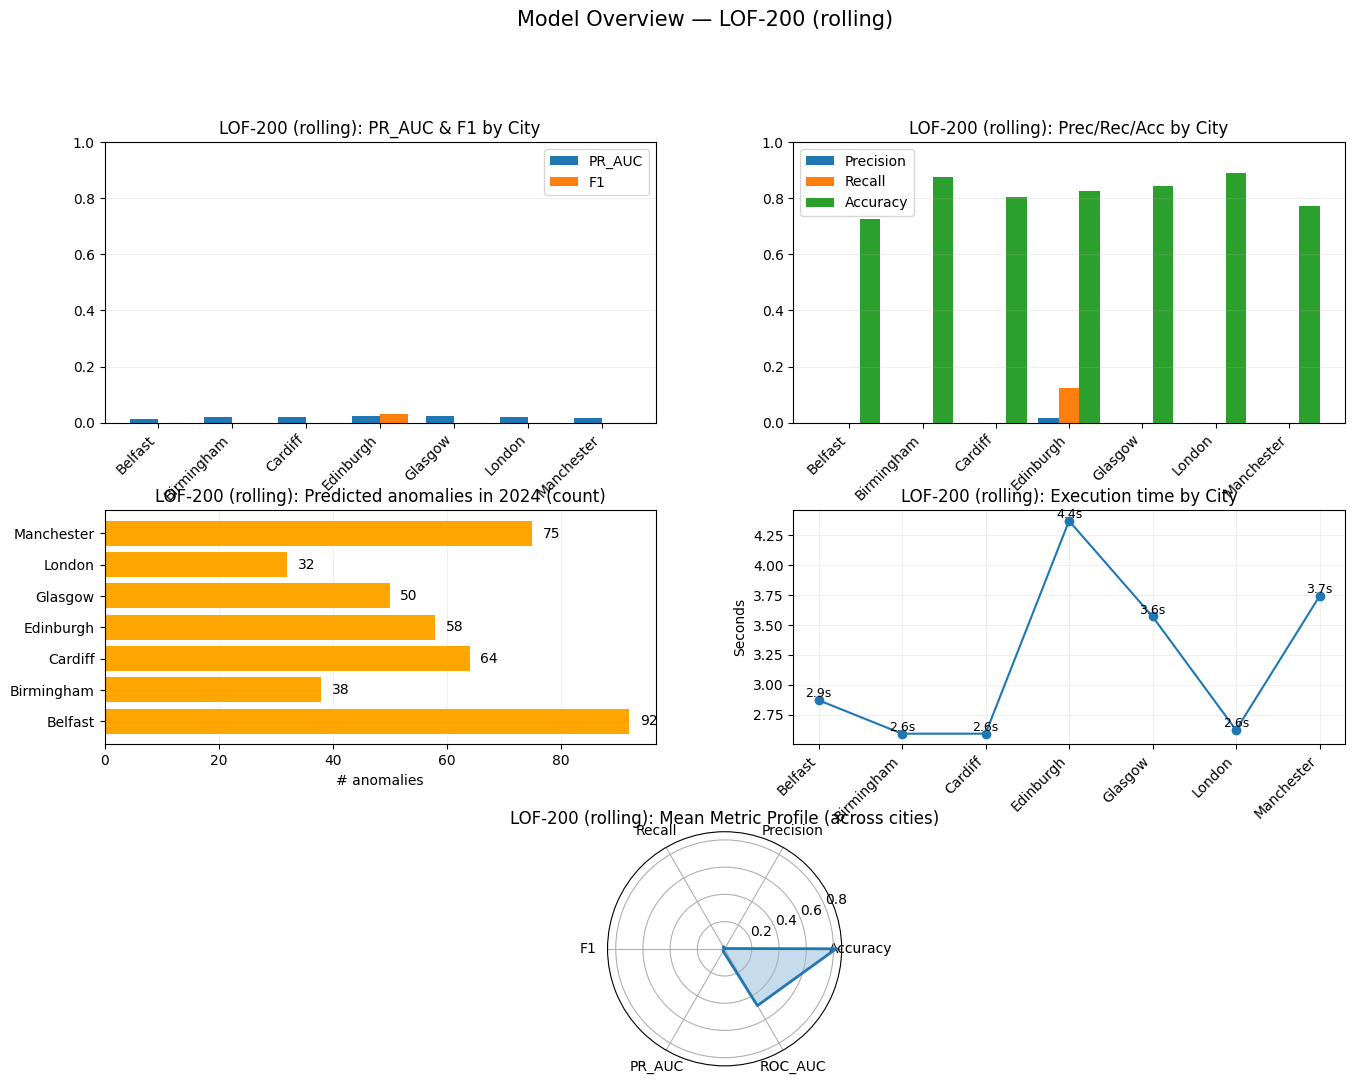

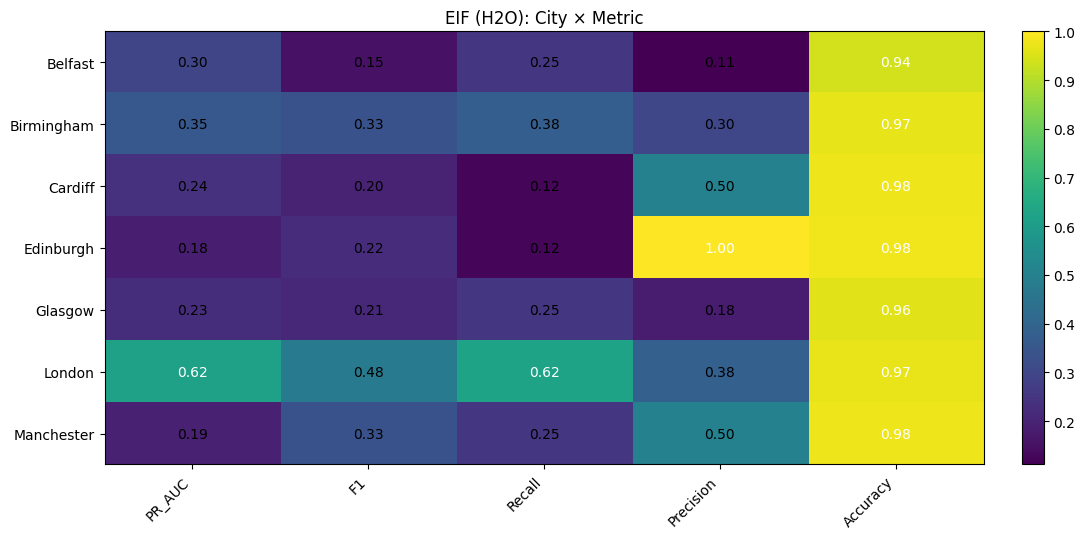

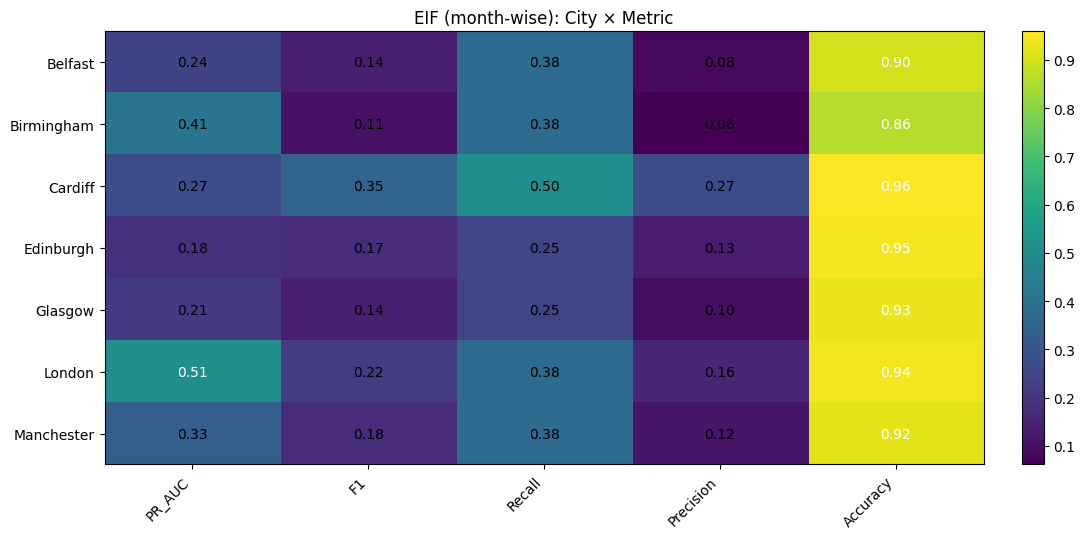

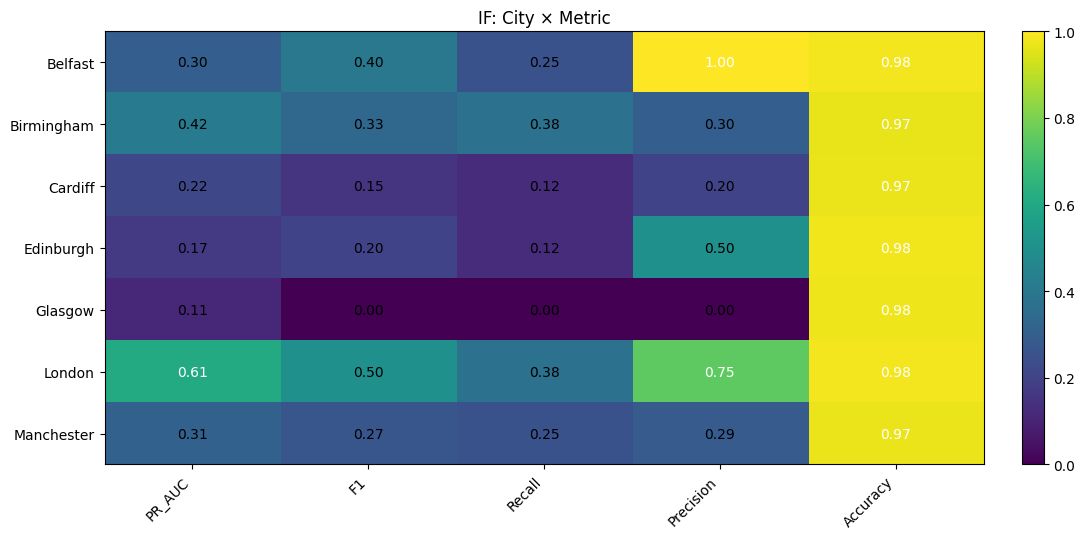

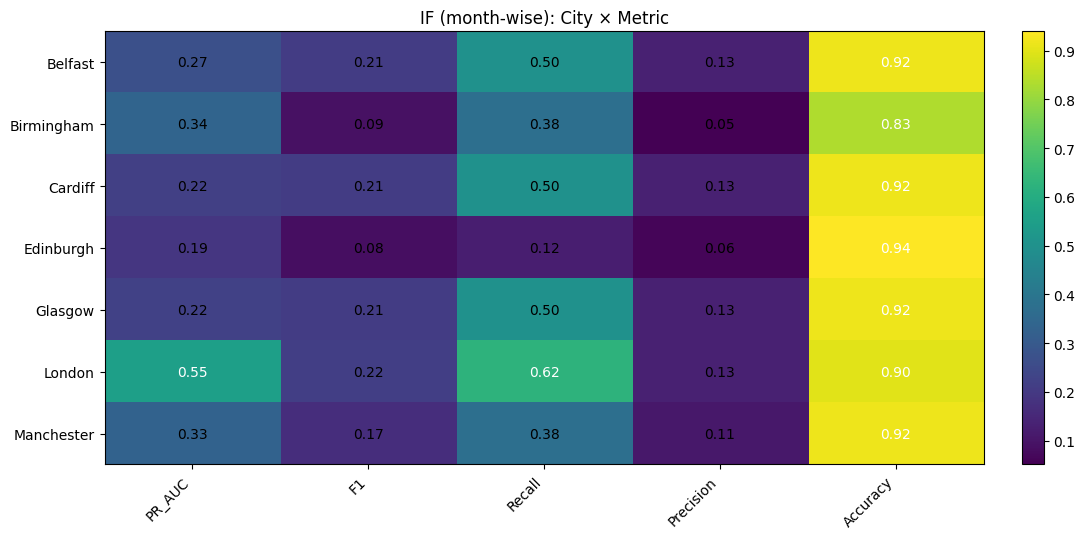

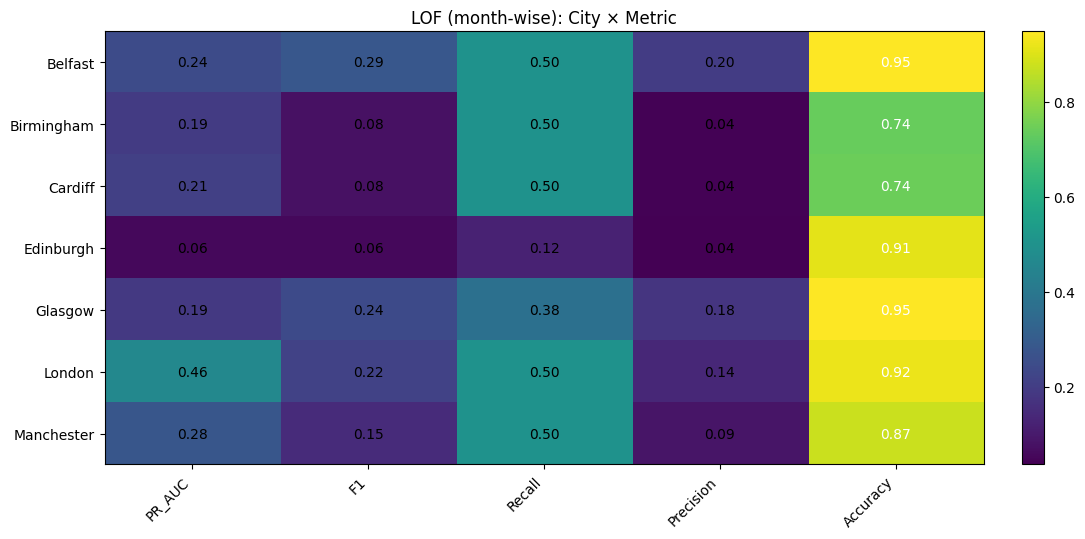

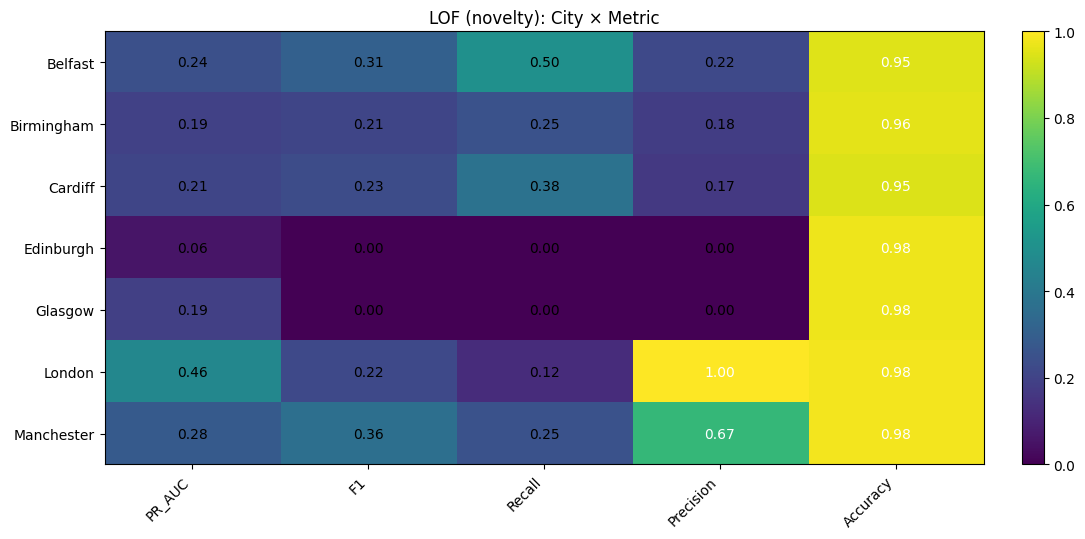

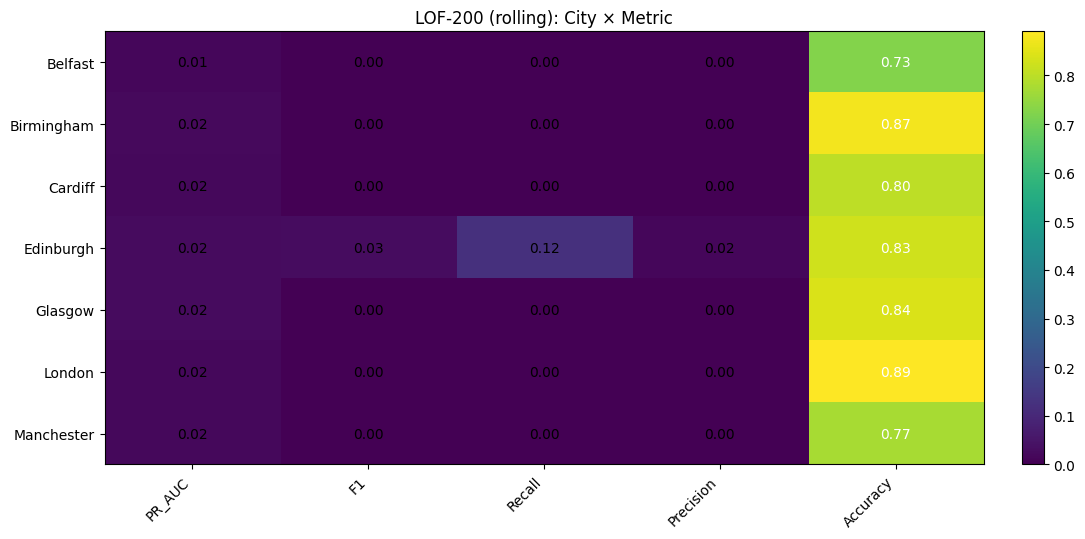

In [ ]:
# Dashboards
for mv in models_list:
    plot_model_overview(mv)

# Heatmaps
for mv in models_list:
    plot_model_heatmaps(mv, metrics=("PR_AUC","F1","Recall","Precision","Accuracy"))


Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         4 hours 9 mins
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.7
H2O_cluster_version_age:    5 months and 2 days
H2O_cluster_name:           H2O_from_python_unknownUser_eqs89w
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    868 Mb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.12.11 final
--------------------------  -----------------------------------------------------------------------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


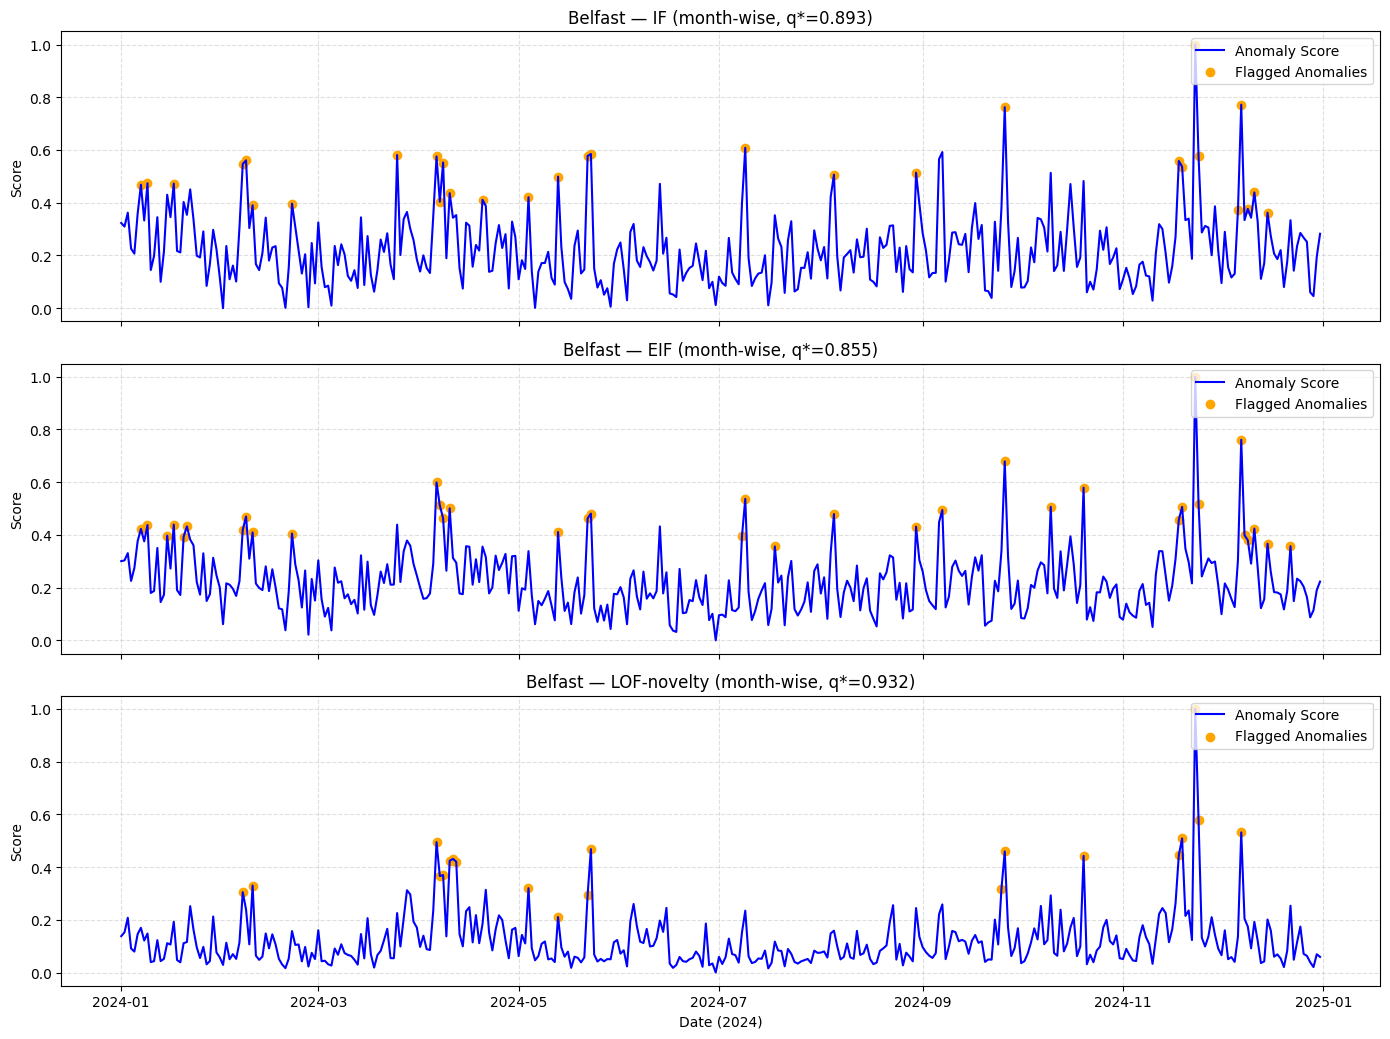

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         4 hours 9 mins
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.7
H2O_cluster_version_age:    5 months and 2 days
H2O_cluster_name:           H2O_from_python_unknownUser_eqs89w
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    859 Mb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.12.11 final
--------------------------  -----------------------------------------------------------------------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


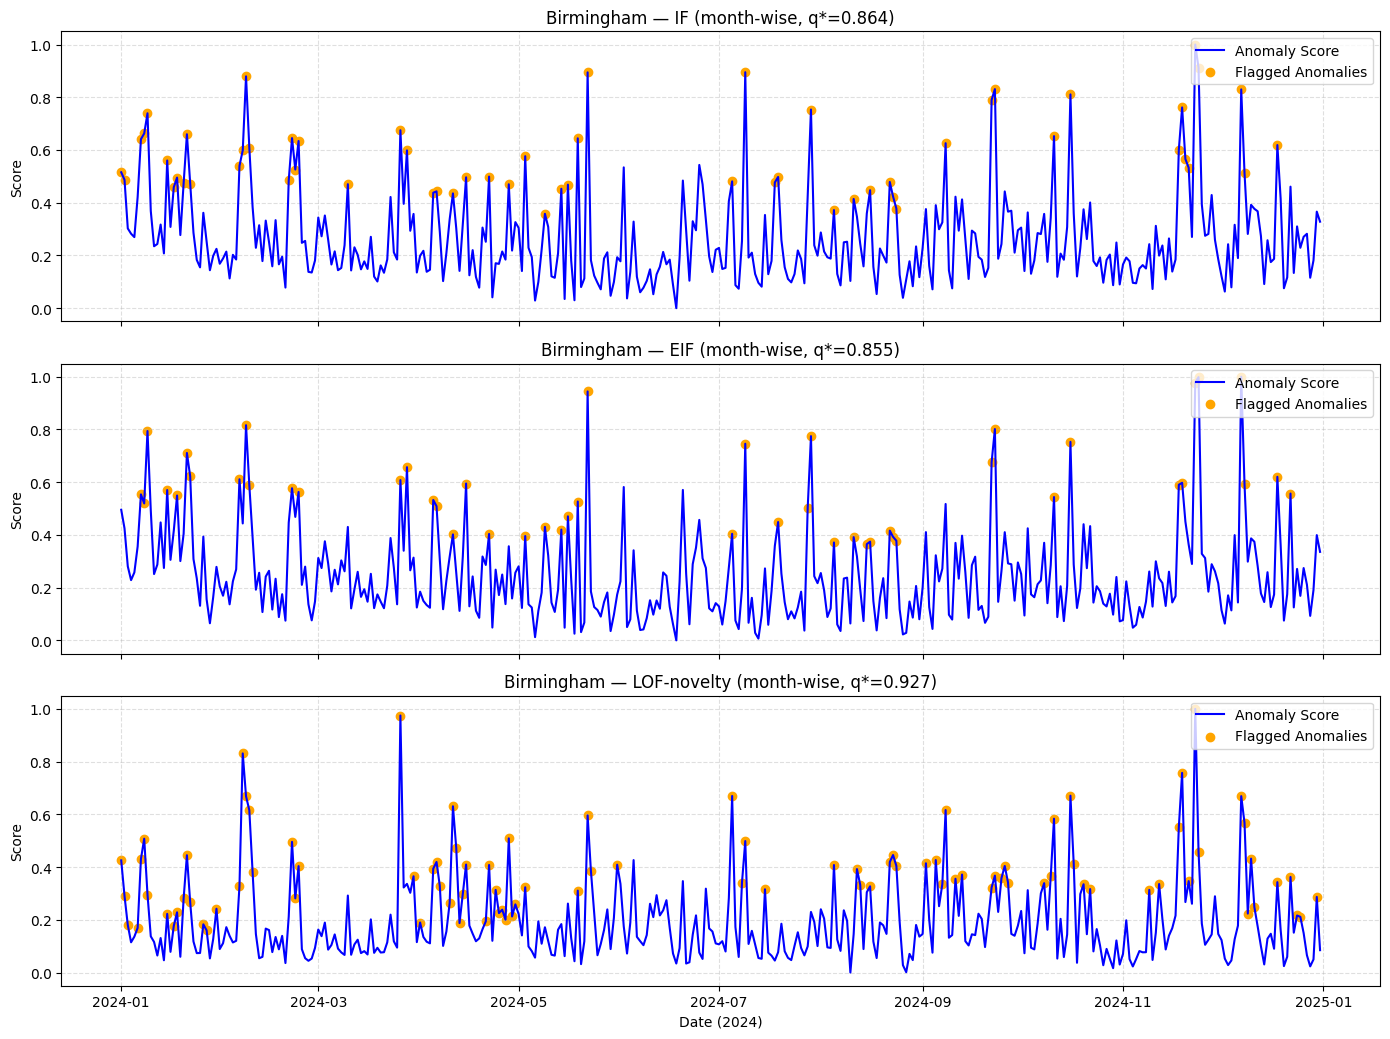

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         4 hours 9 mins
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.7
H2O_cluster_version_age:    5 months and 2 days
H2O_cluster_name:           H2O_from_python_unknownUser_eqs89w
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    789 Mb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.12.11 final
--------------------------  -----------------------------------------------------------------------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


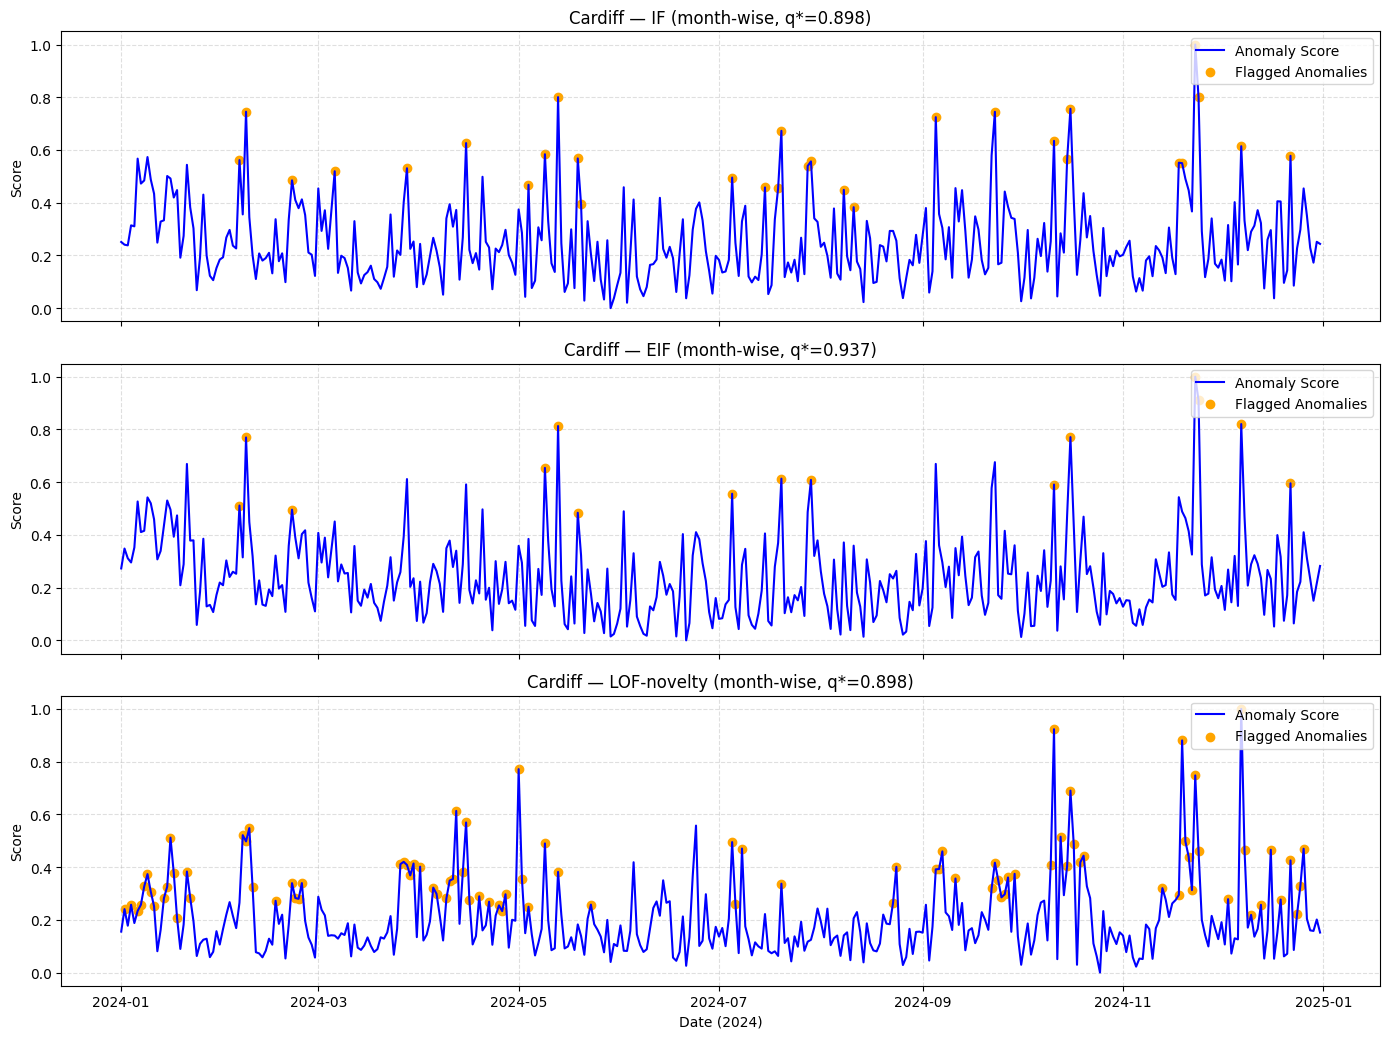

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         4 hours 9 mins
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.7
H2O_cluster_version_age:    5 months and 2 days
H2O_cluster_name:           H2O_from_python_unknownUser_eqs89w
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    777 Mb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.12.11 final
--------------------------  -----------------------------------------------------------------------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


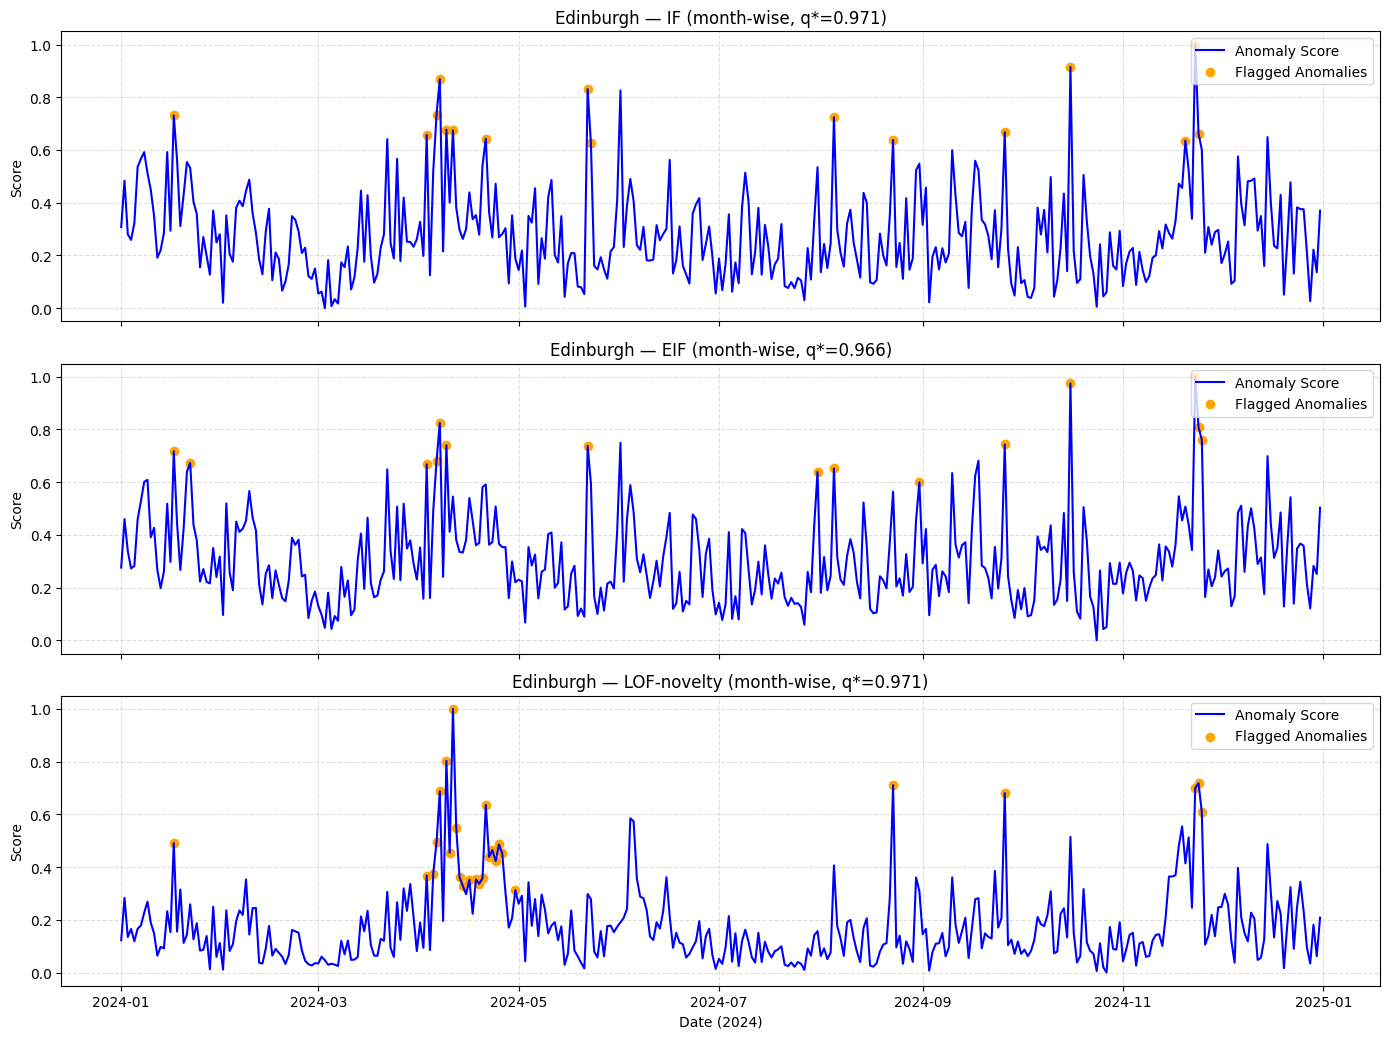

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         4 hours 10 mins
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.7
H2O_cluster_version_age:    5 months and 2 days
H2O_cluster_name:           H2O_from_python_unknownUser_eqs89w
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    744 Mb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.12.11 final
--------------------------  -----------------------------------------------------------------------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


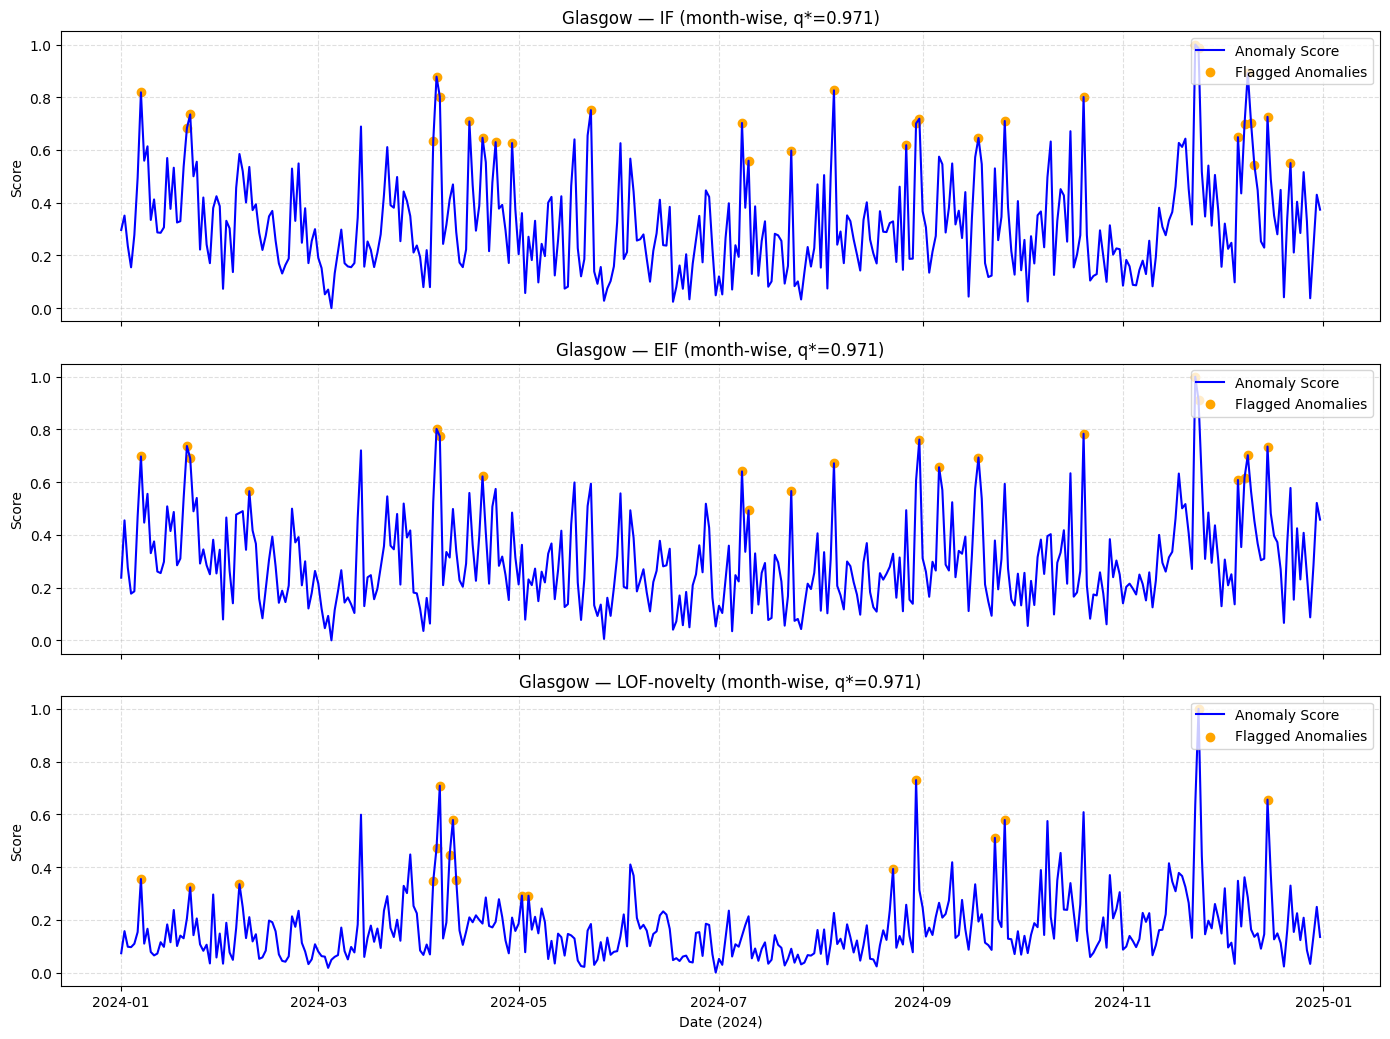

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         4 hours 10 mins
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.7
H2O_cluster_version_age:    5 months and 2 days
H2O_cluster_name:           H2O_from_python_unknownUser_eqs89w
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    686 Mb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.12.11 final
--------------------------  -----------------------------------------------------------------------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


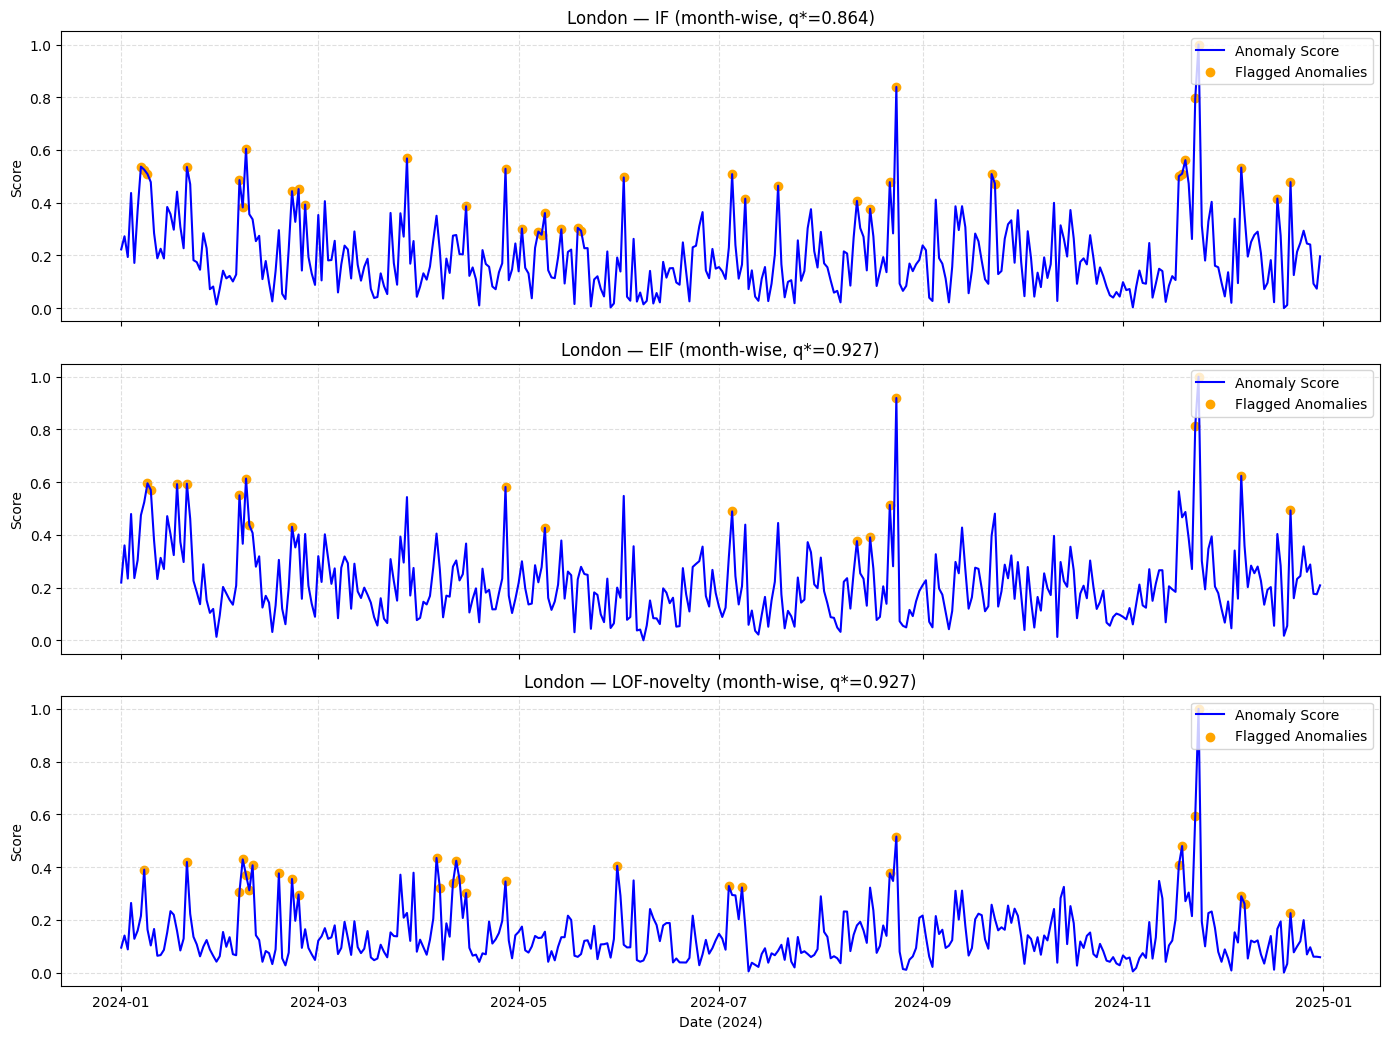

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         4 hours 10 mins
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.7
H2O_cluster_version_age:    5 months and 2 days
H2O_cluster_name:           H2O_from_python_unknownUser_eqs89w
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    713 Mb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.12.11 final
--------------------------  -----------------------------------------------------------------------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |

/usr/local/lib/python3.12/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [MISSINGNESS_SUM_7D, MISSINGNESS_SUM_30D]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


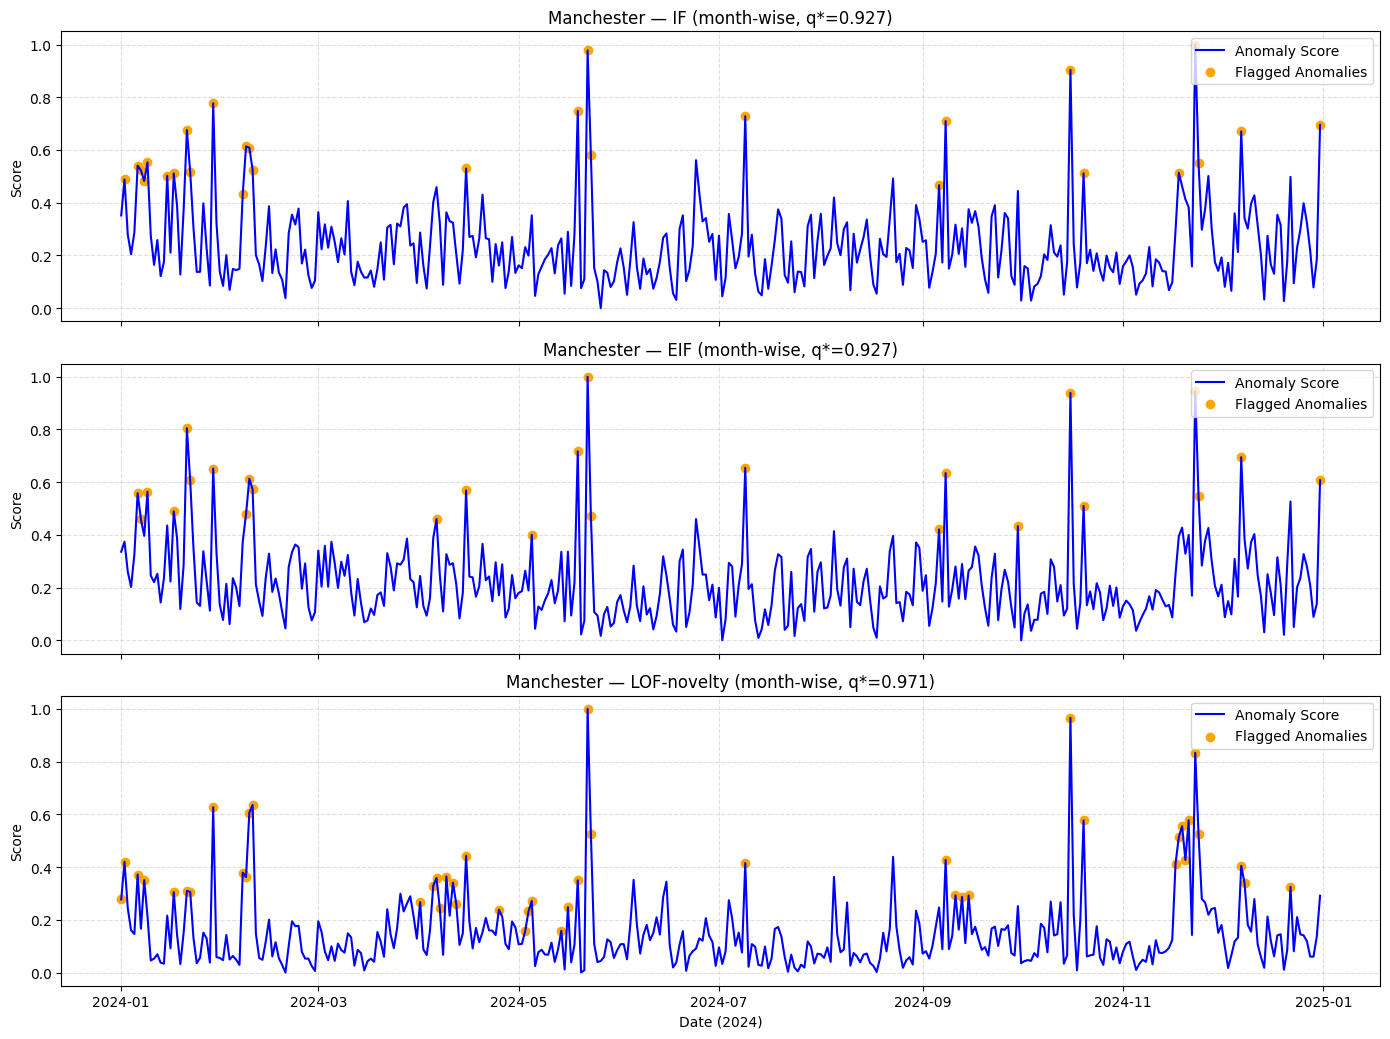

In [ ]:
# Month-wise if available, otherwise global thresholds
for c in cities_list:
    plot_city_timelines(c, include_models=("IF","EIF","LOF-novelty"), prefer_monthwise=True)
